# PIPELINE TO COMPARE NON EMBEDDING NOR SIMULATOR ALGORITHMS
### (I) Block: testing the pre-processing

For preprocessing and Dataset in:
- a) to max noisy
- b) to mean noisy
- c) Saturate at 0.05 noisy
- d) Sigmoid lut noisy
    - d.1 to d.12 : center in 0.1, 0.3, 0.5, 0.7
- e) Opening
- f) Local binarization
        - goiko bixek con diferentes sizes para el elemento estructurante
- e) to max non-noisy
For each one run in a single RAM session the pipe of algorithms:
- Rotation alg. (lanczos and cubic)
- Mirror (lanczos and cubic)
- Naive Relative Affine Rotation
- Relative Rot Phase Correlation Polar Plot
- Histogram Intra-Class variance
- Gravicenter Regression

### (II) Block: Blazquez and Cosine Square Fit

(a) By preprocesisng just with to max noisy, in a single RAM session:
- Cost function w in 0, 0.999, 1
- Con cost w=1 and Ransac or no ransac (params for ransac aldatute)
- Con gravicenter-geometric center or fitted coeff
- Each with Powell and NM

(b) The same for noisy in a new RAM session.

### (III) Block: 

Each DS-NN pair in a different RAM session:
(a) Noisy + CNN simple
(b) Non-Noisy + CNN simple
(c) Noisy + CNN+fc
(d) Non-Noisy + CNN+fc



In [1]:
from IPython.display import HTML, Javascript

def restart_run_all():
    display(HTML(
        '''
            <script>
                code_show = false;
                IPython.notebook.kernel.restart();
                setTimeout(function(){
                        IPython.notebook.execute_all_cells();
                    }, 1000)
                
            </script>
        '''
    ))

import ctypes
import gc

def free():
    gc.collect()
    torch.cuda.empty_cache()
    libc = ctypes.CDLL("libc.so.6")
    libc.malloc_trim(0)
    gc.collect()
    torch.cuda.empty_cache()
    libc = ctypes.CDLL("libc.so.6")
    libc.malloc_trim(0)
    
def skip(line, cell=None):
    '''Skips execution of the current line/cell if line evaluates to True.'''
    if eval(line):
        return

    get_ipython().run_cell(cell) 

def load_ipython_extension(shell):
    '''Registers the skip magic when the extension loads.'''
    shell.register_magic_function(skip, 'line_cell')

def unload_ipython_extension(shell):
    '''Unregisters the skip magic when the extension unloads.'''
    del shell.magics_manager.magics['cell']['skip']
    
    
load_ipython_extension(get_ipython())

In [ ]:
pipe_name="While_in_Greece"

dont_use_experimental = True
dont_use_simulated = False

try:
    f = open(f"META_BLOCK_{pipe_name}.txt", "r")
    current_meta_block = int(f.read())
    f.close()
    f = open(f"BLOCK_{pipe_name}.txt", "r")
    current_block = int(f.read())
    f.close()
    f = open(f"SUB_BLOCK_{pipe_name}.txt", "r")
    current_sub_block = int(f.read())
    f.close()
    

except:
    current_block = 1
    current_sub_block = 1
    current_meta_block = 1

if current_meta_block>3:
    raise ValueError
    
print(current_meta_block, current_block, current_sub_block)

In [2]:
if current_meta_block==1: # use only experimental
    dont_use_simulated = True
    dont_use_experimental = False
else: # use noisy or non noisy simulated! 2, 3 respectively
    dont_use_simulated = True
    dont_use_experimental = False

In [4]:
import os
import json as json
import numpy as np
import pandas as pd
import cv2
from SOURCE.CLASS_CODE_Polarization_Obtention_Algorithms import Rotation_Algorithm, Mirror_Flip_Algorithm
from SOURCE.CLASS_CODE_Image_Manager import Image_Manager
from SOURCE.CLASS_CODE_Ad_Hoc_Optimizer import Ad_Hoc_Optimizer
import matplotlib.pyplot as plt
import torch
import h5py
from styleframe import StyleFrame

assert torch.cuda.is_available(), "GPU is not enabled"
# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

## Pipeline Functions

In [4]:
def angle_to_pi_pi( angle): # convert any angle to range (-pi,pi]\n",
    angle= angle%(2*np.pi) # take it to [-2pi, 2pi]\n",
    return angle-np.sign(angle)*2*np.pi if abs(angle)>np.pi else angle


def compute_expectation_CI(empirical_pdf, boots_samples, confidence):
    resamplings=np.random.choice(empirical_pdf, size=( boots_samples, empirical_pdf.shape[0]))
    boot_means=np.mean(resamplings, axis=1)
    boot_stds=np.std(resamplings, axis=1)
    observed_mean=empirical_pdf.mean()
    observed_std=empirical_pdf.std()
    boots_t=(observed_mean-boot_means)*np.sqrt(empirical_pdf.shape[0])/boot_stds
    boots_t_percentiles = np.percentile(boots_t, q=((100-confidence)/2, confidence+(100-confidence)/2))
    return observed_mean+boots_t_percentiles*observed_std/np.sqrt(empirical_pdf.shape[0])


def plot_histograms_for(category, variable, final_results_df, statistic_df, conf, output_path, bins_log=True):
    categories=len(final_results_df.groupby([category])) # category sería algorithm
                            # variable serían time, absolute error etc.
    columns=1 if categories==1 else 2 if (categories==2 or categories==4) else 3
    rows=categories//3+(categories%3!=0)

    fig=plt.figure(figsize=(7*columns, 5*rows))
    if bins_log:
        bins_main_exponents=np.linspace(-8.5, -3.5, 32 ).tolist()
        bins_main_exponents=[1]+bins_main_exponents+[-1,0]
        #bins_main_exponents=[1,-8.5, -8, -7.5, -7, -6.5,-6,-5.5,-5,-4.5,-4,-3.5,-1,0]
        bins_main=10**np.array(bins_main_exponents)
        bins_main[0]=0
    else:
        bins_main=13
    axs=[]
    maxy=0
    for i, (group_var_val, group_df) in enumerate(final_results_df.groupby([category])):
        axs.append(fig.add_subplot(rows,columns, i+1))
        ns, b, p = axs[-1].hist(group_df[variable], bins=bins_main,
                        label=f"{category}={group_var_val}", 
                        rwidth=1, align='mid', edgecolor="k", alpha=0.6) # range=(0,0.4)
        if bins_log:
            axs[-1].set_xscale('log')
        axs[-1].grid(True)
        axs[-1].axvline(x=statistic_df[variable][f'CI_{conf}_low'][group_var_val], color='m',
                        linestyle='--', label=f'mean {conf} CI', alpha=0.6)
        axs[-1].axvline(x=statistic_df[variable][f'CI_{conf}_up'][group_var_val], color='m', 
                        linestyle='--', alpha=0.6)
        quantiles=np.percentile(group_df[variable], q=((100-conf)/2, conf+(100-conf)/2))
        axs[-1].axvline(x=quantiles[0], color='r', linestyle='--', label=f'{conf} quantiles')
        axs[-1].axvline(x=quantiles[1], color='r', linestyle='--')
        axs[-1].set_title(f"mu {conf}% CI:\n ({statistic_df[variable][f'CI_{conf}_low'][group_var_val]}, \
                          {statistic_df[variable][f'CI_{conf}_up'][group_var_val]})")
        axs[-1].legend()
        maxy = np.max(ns) if np.max(ns)>maxy else maxy
    for ax in axs:
        ax.set_ylim(0,maxy)
    #fig.supylabel('common_y')
    fig.suptitle(f"Histograms for {variable}")
    #fig.suptitle(f"Histogrms for {variable} \n\n Experiment: {experiment_name}\n\n\n The x axes represent the smallest absolute difference between the theoretical\n angle difference and the found angle difference, among the employed algorithms")

    os.makedirs(f"{output_path}/HISTOGRAMS/", exist_ok=True)
    #fig.tight_layout()
    plt.savefig(f"{output_path}/HISTOGRAMS/Histogram_for_{variable}.png", bbox_inches='tight')
    #plt.close()



def run_benchmark_output_result_histograms_and_result_table( algorithm_lambda_list, algorithm_name_list,
                                            references, problems, image_pair_names, generate_algorithm_plots,
                                            generate_histograms, boots_samples=10000, confidence=95,
                                            output_units='rad', ground_truths=None, GT_units=None,
                                            GT_nature = 'phiCR',
                                            experiment_name = None, output_path=None):
    if experiment_name is not None:
        output_path = f"{output_path}/{experiment_name}/"
        os.makedirs(output_path, exist_ok=True)
    # GTs should be in [-pi, pi] or [-180, 180]
    times = {}
    predicted_delta_phiCRs = {}
    
    conv = 180/np.pi if output_units=='deg' else 1
    convGT = 180/np.pi if (output_units=='deg' and GT_units=='rad') else \
        np.pi/180 if (output_units=='rad' and GT_units=='deg') else 1
    print("> Passing Images from each Algorithm...")
    for algorithm, alg_name in zip(algorithm_lambda_list, algorithm_name_list):
        if output_path is not None and generate_algorithm_plots:
            dir_for_alg = output_path+f"/{alg_name}/"
            os.makedirs( dir_for_alg, exist_ok=True )
        else:
            dir_for_alg = None
        predicted_delta_phiCRs[alg_name], times[alg_name] = algorithm(references, problems, dir_for_alg)
        print(f" - Algorithm {alg_name} done!")
        free()
        
    print("\n> Rearranging results in Tables and outputting to Excels...")
    if output_path is not None:
        json.dump({'image_pair_names':image_pair_names, 'predicted_delta_phiCRs':predicted_delta_phiCRs,
              'times':times}, open( f"{output_path}/RAW_results.json", "w"))
    # Rearrange the result to our desired Table and unit formats
    image_ids = []
    image_names = []
    algorithm_names = []
    delta_phiCRs = []
    delta_pols = []
    timess = []
    GTs = []
    abs_errors = []
    free()

    for idx, image_pair_name in enumerate(image_pair_names):
        for algorithm, alg_name in zip(algorithm_lambda_list, algorithm_name_list):
            image_ids.append(idx)
            algorithm_names.append(alg_name)
            image_names.append(image_pair_name)
            delta_phiCRs.append( conv*angle_to_pi_pi(predicted_delta_phiCRs[alg_name][image_pair_name]) ) 
            delta_pols.append( conv*angle_to_pi_pi(predicted_delta_phiCRs[alg_name][image_pair_name])/2.0 )
            timess.append(times[alg_name][image_pair_name])
            if ground_truths is not None:
                GTs.append(convGT*ground_truths[idx])
                if GT_nature=='phiCR':
                    abs_errors.append( np.abs(delta_phiCRs[-1]-convGT*ground_truths[idx]) )
                else: # then GT is of polarization
                    abs_errors.append( np.abs(delta_pols[-1]-convGT*ground_truths[idx]) )
                #correct_decimals.append() # beittu HISTOGRAMAGAZ batera zelan eitten zendun hau!
    table_per_image = pd.DataFrame.from_dict({'ID':image_ids, 'Image_Pair_Name':image_names, 'Algorithm':algorithm_names,
                                   'Predicted_Delta_PhiCRs':delta_phiCRs, 'Pred_Delta_Polarizt':delta_pols,
                                   'Times':timess, f'Ground_Truth_{GT_nature}':GTs, 'Absolute_Error':abs_errors})
    if output_path is not None:
        table_per_image.to_pickle( f"{output_path}/Table_Per_Image_All.pkl")
    print(" - Table per images done!")    
    free()

    # Group by algorithm and generate statistics by analyte (times, absolute_errors etc.)
    groups = table_per_image.groupby('Algorithm')
    stdv = groups[['Absolute_Error', 'Times']].std().fillna(0.0)
    means = groups[['Absolute_Error', 'Times']].mean()
    # Compute confidence intervals using bootstrap
    CIs_time = {}
    CIs_abs_er = {}
    for alg_name, df in table_per_image.groupby('Algorithm'):
        CIs_time[alg_name] = compute_expectation_CI(df['Times'],boots_samples, confidence)
        CIs_abs_er[alg_name] = compute_expectation_CI(df['Absolute_Error'], boots_samples, confidence)
        free()
    CIs_time_df = pd.DataFrame(index=CIs_time.keys(), data=CIs_time.values(), columns=[f'CI_{confidence}_l', f'CI_{confidence}_u'])
    CIs_abs_er_df = pd.DataFrame(index=CIs_abs_er.keys(), data=CIs_abs_er.values(), columns=[f'CI_{confidence}_l', f'CI_{confidence}_u'])
    
    ae = pd.concat([means['Absolute_Error'], stdv['Absolute_Error'],
                    CIs_abs_er_df[f'CI_{confidence}_l'], CIs_abs_er_df[f'CI_{confidence}_u']],
                   keys=['Mean', 'Standard_Dev', f'CI_{confidence}_low', f'CI_{confidence}_up'],axis=1)
    ts = pd.concat([means['Times'], stdv['Times'],
                    CIs_time_df[f'CI_{confidence}_l'], CIs_time_df[f'CI_{confidence}_u']],                   
                   keys=['Mean', 'Standard_Dev', f'CI_{confidence}_low', f'CI_{confidence}_up'],axis=1)
    table_per_alg = pd.concat([ae, ts], keys=['Absolute_Error', 'Times'], axis=1)    
    free()

    if output_path is not None:
        table_per_image.to_pickle( f"{output_path}/Table_Per_Algorithm_Statistics.pkl")
        print(" - Table per algorithm done!")    
        if generate_histograms:
            print("\n> Generating histograms...")
            plot_histograms_for('Algorithm', 'Absolute_Error', table_per_image, table_per_alg, confidence, output_path, bins_log=False)
            plot_histograms_for('Algorithm', 'Times', table_per_image, table_per_alg, confidence, output_path, bins_log=False)
            print("DONE!")
    return table_per_image, table_per_alg

# Generic Routines

In [20]:
def compute_intensity_gravity_center(image):
    """
        Expects input image to be an array of dimensions [h, w].
        It will return an array of gravity centers [2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to numpy indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = np.sum(image, axis=0) # weights for x [raw_width]
    intensity_in_h = np.sum(image, axis=1) # weights for y [raw_height]
    total_intensity = intensity_in_h.sum()

    # Compute mass center for intensity
    # [2] (h_center,w_center)
    return np.nan_to_num( np.stack(
        (np.dot(intensity_in_h, np.arange(image.shape[0]))/total_intensity,
         np.dot(intensity_in_w, np.arange(image.shape[1]))/total_intensity)
        ) )

def compute_raw_to_centered_iX(image, X):

    g_raw = compute_intensity_gravity_center(image)
    # crop the iamges with size (X+1+X)^2 leaving the gravity center in
    # the central pixel of the image. In case the image is not big enough for the cropping,
    # a 0 padding will be made.
    centered_image = np.zeros( (2*X+1, 2*X+1),  dtype = image.dtype )

    # we round the gravity centers to the nearest pixel indices
    g_index_raw = np.rint(g_raw).astype(int) #[N_images, 2]

    # obtain the slicing indices around the center of gravity
    # TODO -> make all this with a single array operation by stacking the lower and upper in
    # a new axis!!
    # [ 2 (h,w)]
    unclipped_lower = g_index_raw[:]-X
    unclipped_upper = g_index_raw[:]+X+1
    # unclippde could get out of bounds for the indices, so we clip them
    lower_bound = np.clip( unclipped_lower, a_min=0, a_max=image.shape)
    upper_bound = np.clip( unclipped_upper, a_min=0, a_max=image.shape)
    # we use the difference between the clipped and unclipped to get the necessary padding
    # such that the center of gravity is left still in the center of the image
    padding_lower = lower_bound-unclipped_lower
    padding_upper = upper_bound-unclipped_upper

    # crop the image
    centered_image[padding_lower[0]:padding_upper[0] or None,
                                    padding_lower[1]:padding_upper[1] or None ] = \
                  image[lower_bound[0]:upper_bound[0],
                                      lower_bound[1]:upper_bound[1]]
    return centered_image



def compute_intensity_gravity_centers_torch( images):
    """
        Expects input image to be an array of dimensions [N_imgs, h, w].
        It will return an array of gravity centers [N_imgs, 2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to array indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = torch.sum(images, dim=1) # weights for x [N_images, raw_width]
    intensity_in_h = torch.sum(images, dim=2) # weights for y [N_images, raw_height]
    total_intensity = intensity_in_h.sum(dim=1) # [N_images]

    # Compute mass center for intensity
    # [N_images, 2] (h_center,w_center)
    return torch.nan_to_num( torch.stack(
        (torch.matmul(intensity_in_h.float(), torch.arange(images.shape[1], 
                                    dtype=torch.float32, device=device))/total_intensity,
         torch.matmul(intensity_in_w.float(), torch.arange(images.shape[2], 
                                    dtype=torch.float32, device=device))/total_intensity),
        dim=1
        ), nan=0.0, posinf=None, neginf=None)


def compute_raws_to_centered_iXs_torch( images, X, device):

    g_raw = compute_intensity_gravity_centers_torch(images) # [ N_images, 2]

    # crop the iamges with size (X+1+X)^2 leaving the gravity center in
    # the central pixel of the image. In case the image is not big enough for the cropping,
    # a 0 padding will be made.
    centered_images = torch.zeros( ( images.shape[0], 2*X+1, 2*X+1),  dtype = images.dtype, 
                                  device=device)

    # we round the gravity centers to the nearest pixel indices
    g_index_raw = torch.round(g_raw).int() #[ N_images, 2]

    # obtain the slicing indices around the center of gravity
    # TODO -> make all this with a single array operation by stacking the lower and upper in
    # a new axis!!
    # [ N_images, 2 (h,w)]
    unclipped_lower = g_index_raw-X
    unclipped_upper = g_index_raw+X+1

    # unclipped could get out of bounds for the indices, so we clip them
    lower_bound = torch.clip( unclipped_lower.float(), min=torch.Tensor([[0,0]]).to(device),
                             max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
    upper_bound = torch.clip( unclipped_upper.float(), min=torch.Tensor([[0,0]]).to(device),
                             max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
    # we use the difference between the clipped and unclipped to get the necessary padding
    # such that the center of gravity is left still in the center of the image
    padding_lower = lower_bound-unclipped_lower
    padding_upper = upper_bound-unclipped_upper

    # crop the image
    for im in range(g_raw.shape[0]):
        centered_images[im, padding_lower[ im, 0]:padding_upper[ im, 0] or None,
                                    padding_lower[ im, 1]:padding_upper[ im, 1] or None] = \
                  images[im, lower_bound[ im, 0]:upper_bound[ im, 0],
                                      lower_bound[ im, 1]:upper_bound[ im, 1]]

    return centered_images

# PRE-PROCESSING FUNCTIONS

## Numpy in out

In [16]:
def normalize_to_max_saturate_and_iX(images,  saturation_threshold, dtype=np.float64,
                              iX_dev='cpu', out_dev='cpu', X=302): # threshold is in [0,1] of max
                                                              # images expected to be [N_images, h, w]
    images = images.astype(dtype)
    maxs = np.expand_dims( np.amax(images, axis=(-2,-1) ), (-2,-1) )
    images = np.where(images<maxs*saturation_threshold, images, 0.0)/maxs
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def normalize_to_mean_saturate_to_max_and_iX(images,  saturation_threshold, dtype=np.float64,
                                     iX_dev='cpu', out_dev='cpu', X=302):  # threshold is in [0,1] of max
                                                                # images expected to be [N_images, h, w]
    images = images.astype(dtype)
    maxs = np.expand_dims( np.amax(images, axis=(-2,-1) ), (-2,-1) )
    images = np.where(images<maxs*saturation_threshold, images, 0.0)/np.expand_dims( np.mean(images, axis=(-2,-1) ), (-2,-1) )
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def normalize_to_mean_saturate_to_mean_and_iX(images,  saturation_threshold, dtype=np.float64,
                                      iX_dev='cpu', out_dev='cpu', X=302):  # threshold is in [0,1] of max
                                                                # images expected to be [N_images, h, w]
    images = images.astype(dtype)
    means = np.expand_dims( np.mean(images, axis=(-2,-1) ), (-2,-1) )
    images = np.where(images<means*saturation_threshold, images, 0.0)/means
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def normalize_to_max_and_iX(images, dtype=np.float64,
                    iX_dev='cpu', out_dev='cpu', X=302): # images expected to be [N_images, h, w]
    images= images.astype(dtype)/np.expand_dims( np.amax(images, axis=(-2,-1) ), (-2,-1) )
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def normalize_to_mean_and_iX(images, dtype=np.float64,
                     iX_dev='cpu', out_dev='cpu', X=302): # images expected to be [N_images, h, w]
    images = images.astype(dtype)/np.expand_dims( np.mean(images, axis=(-2,-1) ), (-2,-1) )
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def sigmoid_lut_and_iX( images, center=0.5, slope_squeezeness=0.085, max_val=255, dtype=np.float64, X=302 ):
    lut = max_val/(1+np.exp(-slope_squeezeness*(np.arange(max_val+1)-center*max_val)))
    images = (lut[ images ]).astype(dtype)
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

## Torch in out

In [17]:
def normalize_to_max_saturate_and_iX_torch(images,  in_are_dev_float, saturation_threshold, 
                                           device, dtype=torch.float32, X=302): # threshold is in [0,1] of max
                                                              # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    maxs = images.abmax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
    images = torch.where(images<maxs*saturation_threshold, images, 0.0)/maxs
    return compute_raws_to_centered_iXs_torch( images, X, device)

def normalize_to_mean_saturate_to_max_and_iX_torch(images,  in_are_dev_float, saturation_threshold, 
                                           device, dtype=torch.float32, X=302):  # threshold is in [0,1] of max
                                                                # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    maxs = images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
    images = torch.where(images<maxs*saturation_threshold, images, 0.0)/torch.mean(images, axis=(-1,-2), keepdims=True)
    return compute_raws_to_centered_iXs_torch( images, X, device)


def normalize_to_mean_saturate_to_mean_and_iX_torch(images,  in_are_dev_float, saturation_threshold, 
                                           device, dtype=torch.float32, X=302):  # threshold is in [0,1] of max
                                                                # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    means=torch.mean(images, axis=(-1,-2), keepdims=True)
    images = np.where(images<means*saturation_threshold, images, 0.0)/means
    return compute_raws_to_centered_iXs_torch( images, X, device)

def normalize_to_max_and_iX_torch(images, in_are_dev_float, 
                                device, dtype=torch.float32, X=302): # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    return compute_raws_to_centered_iXs_torch(images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)), X, device)


def normalize_to_mean_and_iX_torch(images, in_are_dev_float, 
                                device, dtype=torch.float32, X=302): # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    return compute_raws_to_centered_iXs_torch(images/torch.mean(images, axis=(-1,-2), keepdims=True), X, device)


def sigmoid_lut_using_numpy_normalize_and_iX( images, in_are_dev, device, center=0.5, 
                       slope_squeezeness=0.085, max_val_lut_process=255, lut_process_dtype=torch.uint8,
                       output_dtype=torch.float64, X=302 ):
    if not in_are_dev:
        images = images.to(device)
    images = (max_val_lut_process*(images.type(torch.float64)/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)))
                 ).type(lut_process_dtype)
    
    lut = (max_val_lut_process/(1+np.exp(-slope_squeezeness*(np.arange(max_val_lut_process+1)-
                                                               center*max_val_lut_process))))
    images = torch.from_numpy(lut[ images.to('cpu').numpy() ]).to(device).type(output_dtype)
    return compute_raws_to_centered_iXs_torch(images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)), X, device)
# Ojo! se usan los valores float del lut como valores de la imagen! (no los cuantizados!)

def sigmoid_no_lut_normalize_and_iX( images, in_are_dev_float, device, center=0.7, 
                       slope_squeezeness=50, dtype=torch.float64, X=302 ):
    if not in_are_dev_float:
        images = images.type(dtype).to(device)    
    images = images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))   # normalize
    images = 1.0/(1+torch.exp(-slope_squeezeness*(images-center)))
    return compute_raws_to_centered_iXs_torch(images, X, device) # we need not noramlize them again if center if sigmoid chosen with sense


# (A) ROTATION ALGORITHM

In [13]:
# input images expected for all cases to be float64 and normalized to unity
# also, at least in this case, expected to be numpy arrays!
# Input expected to be alread [n, 2X+1, 2X+1] centered in gravicenter!
def run_rotation_algorithm(references, problems, image_pair_names, preprocess_fct, search_algorithm, 
                       search_alg_kw_args, rotation_alg_kw_args, out_plot_path=None, rotation_algorithm=None):
    predicted_deltaPhiCRs={}
    times={}
    
    image_loader = Image_Manager(mode=X, interpolation_flag=None)
    if rotation_algorithm is None:
        rotation_algorithm = Rotation_Algorithm(image_loader,
            rotation_alg_kw_args['theta_min_Rot'], rotation_alg_kw_args['theta_max_Rot'], 
            rotation_alg_kw_args['interpolation_flag'],
            rotation_alg_kw_args['initial_guess_delta_rad'], rotation_alg_kw_args['use_exact_gravicenter'], 
                                                initialize_it=False)
    image_names = []
    for mode in ['Ref', 'Pb']:
        for image_pair_name in image_pair_names:
            image_names.append(f"{mode}__{image_pair_name}")
    # charge the image loader:
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)
    image_loader.import_converted_images_as_array(images, image_names)
    # Execute the Rotation Algorithm:
    rotation_algorithm.interpolation_flag=rotation_alg_kw_args['interpolation_flag']
    rotation_algorithm.reInitialize(image_loader)
    # run it
    if search_algorithm=='quadratic':
        rotation_algorithm.quadratic_fit_search(search_alg_kw_args['precision_quadratic'], 
                            search_alg_kw_args['max_it_quadratic'], search_alg_kw_args['cost_tolerance_quadratic'])
    else: # 'fibo'
        rotation_algorithm.fibonacci_ratio_search(search_alg_kw_args['precision_fibonacci'],
                    search_alg_kw_args['max_points_fibonacci'], search_alg_kw_args['cost_tolerance_fibonacci'])    
    if out_plot_path is not None:
        rotation_algorithm.save_result_plots_fibonacci_or_quadratic(out_plot_path)
    
    angles = list(rotation_algorithm.angles.values())
    ts = list(rotation_algorithm.times.values())
    
    for i, imagep_n in enumerate(image_pair_names):
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(angles[i+len(image_pair_names)]) - angle_to_pi_pi(angles[i]) # pb - ref
        times[imagep_n] = ts[i+len(image_pair_names)] + ts[i]
            
    return predicted_deltaPhiCRs, times

# (B) MIRROR FLIP ALGORITHM

In [14]:

# input images expected for all cases to be float64 and normalized to unity
# also, at least in this case, expected to be numpy arrays!
# Input expected to be alread [n, 2X+1, 2X+1] centered in gravicenter!
def run_mirror_flip_algorithm(references, problems, image_pair_names, preprocess_fct, search_algorithm, 
                       search_alg_kw_args, mirror_alg_kw_args, out_plot_path=None, mirror_algorithm=None):
    predicted_deltaPhiCRs={}
    times={}
    
    image_loader = Image_Manager(mode=X, interpolation_flag=None)
    if mirror_algorithm is None:
        mirror_algorithm = Mirror_Flip_Algorithm(image_loader,
            mirror_alg_kw_args['theta_min_Mir'], mirror_alg_kw_args['theta_max_Mir'], 
            mirror_alg_kw_args['interpolation_flag'],
            mirror_alg_kw_args['initial_guess_delta_rad'], method="aff", left_vs_right=True, 
            use_exact_gravicenter=mirror_alg_kw_args['use_exact_gravicenter'], initialize_it=False)

    image_names = []
    for mode in ['Ref', 'Pb']:
        for image_pair_name in image_pair_names:
            image_names.append(f"{mode}__{image_pair_name}")
    # charge the image loader:
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)
    image_loader.import_converted_images_as_array(images, image_names)
    # Execute the Rotation Algorithm:
    mirror_algorithm.interpolation_flag=mirror_alg_kw_args['interpolation_flag']
    mirror_algorithm.reInitialize(image_loader)
    # run it
    if search_algorithm=='quadratic':
        mirror_algorithm.quadratic_fit_search(search_alg_kw_args['precision_quadratic'], 
                            search_alg_kw_args['max_it_quadratic'], search_alg_kw_args['cost_tolerance_quadratic'])
    else: # 'fibo'
        mirror_algorithm.fibonacci_ratio_search(search_alg_kw_args['precision_fibonacci'],
                    search_alg_kw_args['max_points_fibonacci'], search_alg_kw_args['cost_tolerance_fibonacci'])    
    
    if out_plot_path is not None:
        mirror_algorithm.save_result_plots_fibonacci_or_quadratic(out_plot_path)
    
    angles = list(mirror_algorithm.angles.values())
    ts = list(mirror_algorithm.times.values())
    
    for i, imagep_n in enumerate(image_pair_names):
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(angles[i+len(image_pair_names)]) - angle_to_pi_pi(angles[i]) # pb - ref
        times[imagep_n] = ts[i+len(image_pair_names)] + ts[i]
    
    return predicted_deltaPhiCRs, times

# (D) Naive Affine Rotation

In [17]:
class Naive_Affine_Rotation():
    def __init__(self, X, min_angle, max_angle, interpolation_flag, initial_guess_delta, use_exact_gravicenter):
        #Polarization_Obtention_Algorithm.__init__(self,image_loader, use_exact_gravicenter)
        #self.original_images = image_loader
        self.mode = X
        self.use_exact_gravicenter=use_exact_gravicenter
        self.angles={}
        self.precisions={}
        
        self.interpolation_flag = interpolation_flag
        self.min_angle = min_angle
        self.max_angle = max_angle
        self.initial_guess_delta = initial_guess_delta
        self.computed_points={}
        self.optimums={}
        self.optimals={}
        self.times={}
        self.cols=np.broadcast_to( np.arange(self.mode*2+1), (self.mode*2+1,self.mode*2+1)) #[h,w]
        self.optimizer = Ad_Hoc_Optimizer(min_angle, max_angle, initial_guess_delta, self.evaluate_image_rotation)
        
    def reInitialize_and_input_images(self, ref_images, pb_images, image_pair_names):     
        # Reference image in position k is the reference for the problem image in position k
        # both arrays will be [N_im, H,W]            
        self.reference_images = ref_images
        self.problem_images = pb_images
        self.image_pair_names = image_pair_names
        
        self.angles={}
        self.precisions={}
        self.computed_points={}
        self.optimums={}
        self.optimals={}
        self.times={}
        self.cols=np.broadcast_to( np.arange(self.mode*2+1), (self.mode*2+1,self.mode*2+1)) #[h,w]
        
        if self.use_exact_gravicenter: # GRAVICENTRUM KALKULEU!
            self.grav_ref = self.compute_intensity_gravity_centers(ref_images) #[N_images, 2(h,w)]
            self.grav_pb = self.compute_intensity_gravity_centers(pb_images)
        else:
            # gravicenter the same for all
            self.grav=np.array(2*[self.mode])+0.5

    def angle_to_pi_pi(self, angle): # convert any angle to range ()-pi,pi]
        angle= angle%(2*np.pi) # take it to [-2pi, 2pi]
        return angle-np.sign(angle)*2*np.pi if abs(angle)>np.pi else angle

    
    def compute_intensity_gravity_centers(self, images):
        """
            Expects input images to be an array of dimensions [N_images, h, w].
            It will return an array of gravity centers [N_images, 2(h,w)] in pixel coordinates
            Remember that pixel coordinates are set equal to numpy indices, so they being at 0
        """
        # image wise total intensity and marginalized inensities for weighted sum
        # (preserves axis 0, where images are stacked)
        intensity_in_w = np.sum(images, axis=1) # weights for x [N_imgs, raw_width]
        intensity_in_h = np.sum(images, axis=2) # weights for y [N_imgs, raw_height]
        total_intensity = intensity_in_h.sum(axis=1)

        # Compute mass center for intensity (in each image axis)
        # [N_images, 2] (h_center,w_center)
        return np.nan_to_num( np.stack(
            (np.dot(intensity_in_h, np.arange(images.shape[-2]))/total_intensity,
             np.dot(intensity_in_w, np.arange(images.shape[-1]))/total_intensity)
            ).transpose() )

    def rotate_image_by(self, image_array, angle, center):
        """
        Center is expected to be a point [h,w]
        """
        a=np.cos(angle)
        b=np.sin(angle)
        rot_mat=np.float64([[a, b, center[1]*(1-a)-center[0]*b],
                             [-b, a, center[1]*b+center[0]*(1-a)]])
        return cv2.warpAffine(image_array, rot_mat, image_array.shape, flags=self.interpolation_flag).astype(image_array.dtype)
     
    def translate_image_and_rotate_by(self, image_array, angle, rotation_center, translation):
        """
        first translation then rotation about that special center is done
        rotation_center is expected to be a point [h,w]
        the translation is expected to be a point [h,w]
        """
        a=np.cos(angle)
        b=np.sin(angle)
        rot_mat=np.float64(
                [[a, b, translation[1]*a+translation[0]*b+rotation_center[1]*(1-a)-rotation_center[0]*b],
                 [-b, a, -translation[1]*b+translation[0]*a+rotation_center[1]*b+rotation_center[0]*(1-a)]])
        return cv2.warpAffine(image_array, rot_mat, image_array.shape, flags=self.interpolation_flag).astype(image_array.dtype)


    def evaluate_image_rotation(self, reference_image, angle, image_to_rotate, center_ref, center_pb):
        return np.sum(np.abs(self.translate_image_and_rotate_by(
                                image_to_rotate, angle, center_ref, center_ref-center_pb)
                             -reference_image))


    def given_axis_angle_greater_minus_lower(self, angle, image, center):
        # such that if the output is positive, then R has more intensity and you know immediately that the good angle is the bigger one?
        # de fet esto sugiere un algoritmo con el polano ortogonal que directamente te encuentra el angulo que toca, pero bueno con los que buscan el eje simetrico el truco no parece que funcionara
        mask=np.less(self.cols.swapaxes(0,1), np.tan(-angle)*(self.cols-center[1])+center[0]) #[h,w] We set -angle, because the coordinates we are thinking of are a mirror flip in w
            # also, we use less instead of greater because we are really thinking on the mirror fliped axes on w
        return np.sum(image[mask])-np.sum(image[np.logical_not(mask)])

    def get_polarization_angle(self, angle, image, center):
        """
        All the mirror methods have the problem that we only get the
        correct angle up to an angle pi. In order to know which is the
        angle to the maximum of the ring (and not the minimum) a final
        subtle check is required.
        """
        #if angle==np.pi or 0: In this case the correct one is not defined by this alg!!!
        if angle==0 or abs(angle)==np.pi:
            angle+=1e-12 # this solution is not ideal, but it works, since we will never get such a good precision
        diff=self.given_axis_angle_greater_minus_lower(angle+np.pi/2, image, center)

        if diff>0: # then Upper>Lower -> then good one is the one in (0,pi)
            return angle+np.pi if angle<0 else angle
        else:
            return angle-np.pi if angle>0 else angle

    def brute_force_search(self, angle_steps, zoom_ratios):
        """
        What does this exactly do

        Arguments
        --------
        - angle_steps (list): A list of the different angle steps to take in each of the sweeps.
            Expected N, where N is the number of sweeps that will be performed. The first one is
            expected to be the coarsest grain and they should be ordered from big to smallest.
            The last step in the list will define the precision of the found minimum. The angle
            steps are expected to be in (0, 2pi)

        - zoom_ratios (list): A list of the interval reductions that will be held after each sweep
            around the current best candidate for the minimum. There should be N-1 elements and
            they should be numbers in (0,1].

        """
        zoom_ratios.append(1) #to avoid out of index in the last iteration
        for im, image_pair_name in enumerate(self.image_pair_names):
            name=f"Brute_Force_{image_pair_name}"
            (self.times[name],
            self.computed_points[name],
            self.optimals[name],
            self.optimums[name],
            self.precisions[name]) = self.optimizer.brute_force_search(
                    angle_steps, zoom_ratios,
                    self.reference_images[im], (self.problem_images[im],
                    self.grav_ref[im] if self.use_exact_gravicenter else self.grav,
                    self.grav_pb[im] if self.use_exact_gravicenter else self.grav
                            ))
            self.optimals[name][f"Stage_{len(angle_steps)-1}"] =self.angle_to_pi_pi(self.optimals[name][f"Stage_{len(angle_steps)-1}"])
            self.angles[name]=-self.get_polarization_angle(self.optimals[name][f"Stage_{len(angle_steps)-1}"], self.images_float[im],
                self.grav[im] if self.use_exact_gravicenter else self.grav
            )


    def fibonacci_ratio_search(self, precision, maximum_points, cost_tol):
        """
        Arguments
        --------
        - precision (float): Half the length of the interval achieved in the last step. It will be
            the absolute error to which we compute the minimum of the funtion. Note however that
            the precision will have a minimum depending on the image quality and the minimum
            rotation arithmetics. Noise or discretization can induce plateaus in the minimum.
            Therefore, if at some point the three points have the same cost function the algorithm
            will stop: the cost function has arrived to the plateau. In that case the precision will
            be outputed accordingly.

        - maximum_points (int): Maximum number of points to use in the minimum search. It is also
            the number of times to make an interval reduction.

        - cost_tol (float): Maximum relative difference between the cost function active points
            tolerated before convergence assumption.
        """

        for im, image_pair_name in enumerate(self.image_pair_names):
            name=f"Fibonacci_Search_{image_pair_name}"
            (self.times[name],
            self.computed_points[name],
            optimal,
            self.optimums[name],
            self.precisions[name])=         self.optimizer.fibonacci_ratio_search(
                    precision, maximum_points, cost_tol,
                    self.reference_images[im], (self.problem_images[im],
                    self.grav_ref[im] if self.use_exact_gravicenter else self.grav,
                    self.grav_pb[im] if self.use_exact_gravicenter else self.grav
                                                                   ))
            self.optimals[name]=self.angle_to_pi_pi(optimal)
            #self.angles[name]=self.get_polarization_angle(self.optimals[name]/2, self.images_float[im],
            #    self.grav[im] if self.use_exact_gravicenter else self.grav)
            self.angles[name]=-self.optimals[name]

    def quadratic_fit_search(self, precision, max_iterations, cost_tol):
        """
        Quadratic

        Arguments
        --------
        - precision (float): Half the length of the interval achieved in the last step. It will be
            the absolute error to which we compute the minimum of the funtion. Note however that
            the precision will have a minimum depending on the image quality and the minimum
            rotation arithmetics. Noise or discretization can induce plateaus in the minimum.
            Therefore, if at some point the three points have the same cost function the algorithm
            will stop: the cost function has arrived to the plateau. In that case the precision will
            be outputed accordingly.

        - max_iterations (int): Number of maximum iterations of quadratic function fit and
            minimization to tolerate.

        - cost_tol (float): Maximum relative difference between the cost function active points
            tolerated before convergence assumption.

        """
        for im, image_pair_name in enumerate(self.image_pair_names):
            name=f"Quadratic_Search_{image_pair_name}"
            (self.times[name],
            self.computed_points[name],
            optimal,
            self.optimums[name],
            self.precisions[name])=self.optimizer.quadratic_fit_search(
                precision, max_iterations, cost_tol,
                self.reference_images[im], (self.problem_images[im],
                    self.grav_ref[im] if self.use_exact_gravicenter else self.grav,
                    self.grav_pb[im] if self.use_exact_gravicenter else self.grav))
            self.optimals[name]=self.angle_to_pi_pi(optimal)
            #self.angles[name]=self.get_polarization_angle(self.optimals[name]/2, self.images_float[im],
            #    self.grav[im] if self.use_exact_gravicenter else self.grav)
            self.angles[name] = -self.optimals[name]

    def save_result_plots_fibonacci_or_quadratic(self, output_path):
        """
        Save the resulting explored points in cost function vs angle, together with the info
        about the optimization.
        """
        os.makedirs(f"{output_path}/Rotation_Algorithm/", exist_ok=True)
        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot(1, 1, 1)
        for name, computed_points in self.computed_points.items():
            ax.plot(computed_points[:,0], computed_points[:,1], 'o', label=name)
            ax.set_title(f"Polarization Angle = {self.angles[name]}+-{self.precisions[name]/2} rad\nOptimal={self.optimals[name]}+-{self.precisions[name]} rad\nComputed Points={len(computed_points)} . Time Required={self.times[name]}s")
            ax.set_xlabel("Angle (rad)")
            ax.set_ylabel("|Rotated-Original|")
            #ax.set_yscale('log')
            ax.grid(True)
            plt.savefig(f"{output_path}/Rotation_Algorithm/{name}.png")
            ax.clear()

    def save_result_plots_brute_force(self, output_path):
        os.makedirs(f"{output_path}/Rotation_Algorithm/", exist_ok=True)
        fig, axes = plt.subplots(len(next(iter(self.times.values())).values()), 1, figsize=(10,15))
        fig.tight_layout(pad=5.0)
        for name, computed_points in self.computed_points.items():
            for stage, ax in enumerate(axes):
                ax.clear()
                ax.plot(computed_points[f"Stage_{stage}"][:,0],
                    computed_points[f"Stage_{stage}"][:,1], 'o', markersize=2,
                    label=f"{name}_Stage_{stage}")
                ax.set_title(f"STAGE {stage}: Optimal angle={self.optimals[name][f'Stage_{stage}']}+-{self.precisions[name][f'Stage_{stage}']} rad\nComputed Points={len(computed_points[f'Stage_{stage}'])}. Time Required={self.times[name][f'Stage_{stage}']}s")
                ax.set_xlabel("Angle (rad)")
                ax.set_ylabel("|Rotated-Original|")
                #ax.set_yscale('log')
                ax.grid(True)
            fig.suptitle(f"Polarization angle=Polarization Angle={self.angles[name]}+-{self.precisions[name][f'Stage_{len(axes)-1}']/2} rad")
            plt.savefig(f"{output_path}/Rotation_Algorithm/{name}.png")
            self.precisions[name]=self.precisions[name][f'Stage_{stage}']


In [18]:
# input images expected for all cases to be float64 and normalized to unity
# also, at least in this case, expected to be numpy arrays!
# Input expected to be alread [n, 2X+1, 2X+1] centered in gravicenter!
def run_naive_affine_rotation_algorithm(references, problems, image_pair_names, preprocess_fct, search_algorithm, 
                       search_alg_kw_args, rotation_alg_kw_args, out_plot_path=None, rotation_algorithm=None):
    predicted_deltaPhiCRs={}
    times={}
    
    if rotation_algorithm is None:
        rotation_algorithm = Naive_Affine_Rotation( rotation_alg_kw_args['X'],
            rotation_alg_kw_args['theta_min_Rot'], rotation_alg_kw_args['theta_max_Rot'], 
            rotation_alg_kw_args['interpolation_flag'],
            rotation_alg_kw_args['initial_guess_delta_rad'], rotation_alg_kw_args['use_exact_gravicenter'])
        
    # charge the image loader:
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)

    references = images[:references.shape[0]]
    problems = images[references.shape[0]:]
    # Execute the Rotation Algorithm:

    rotation_algorithm.reInitialize_and_input_images(references, problems, image_pair_names)
    # run it
    if search_algorithm=='quadratic':
        rotation_algorithm.quadratic_fit_search(search_alg_kw_args['precision_quadratic'], 
                            search_alg_kw_args['max_it_quadratic'], search_alg_kw_args['cost_tolerance_quadratic'])
    else: # 'fibo'
        rotation_algorithm.fibonacci_ratio_search(search_alg_kw_args['precision_fibonacci'],
                    search_alg_kw_args['max_points_fibonacci'], search_alg_kw_args['cost_tolerance_fibonacci'])    
    if out_plot_path is not None:
        rotation_algorithm.save_result_plots_fibonacci_or_quadratic(out_plot_path)
    
    angles = list(rotation_algorithm.angles.values())
    ts = list(rotation_algorithm.times.values())
    
    for i, imagep_n in enumerate(image_pair_names):
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(angles[i]) # pb - ref
        times[imagep_n] = ts[i]
            
    return predicted_deltaPhiCRs, times

# (E) Fourier Space Phase Correlation for Polar Coordinate Image

In [19]:

from skimage.registration import phase_cross_correlation
from skimage.transform import warp_polar
from time import time

# input images expected for all cases to be float64 and normalized to unity
# also, at least in this case, expected to be numpy arrays!
# Input expected to be alread [n, 2X+1, 2X+1] centered in gravicenter!
def run_polar_fourier_phase_correlation(references, problems, image_pair_names, preprocess_fct, 
                            get_grav_fct, polar_fourier_alg_kw_args):
    predicted_deltaPhiCRs={}
    times={}
     
    # preprocess the images the image loader:
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)

    references = images[:references.shape[0]]
    problems = images[references.shape[0]:]
    # Execute the Rotation Algorithm:

    if polar_fourier_alg_kw_args['use_exact_gravicenter']:
        centers_pbs = get_grav_fct(problems) #[N_pbs, 2]
        centers_refs = get_grav_fct(references)
    else:
        centers_pbs = np.repeat(np.array([[polar_fourier_alg_kw_args['X'], 
                                          polar_fourier_alg_kw_args['X']]]), 
                               len(problems), axis=0)
        centers_refs = np.repeat(np.array([[polar_fourier_alg_kw_args['X'], 
                                          polar_fourier_alg_kw_args['X']]]), 
                               len(references), axis=0)
    
    if  type(references)==torch.Tensor or type(problems)==torch.Tensor:
        references = references.to('cpu').numpy()
        problems = problems.to('cpu').numpy()

    
    predicted_deltaPhiCRs={}
    times={}
    # run it
    for ref_im, pb_im, cent_ref, cent_pb, imagep_n in zip(references, problems, centers_refs, centers_pbs, image_pair_names):
        t0=time()
        im_ref_polar = warp_polar(ref_im, center=cent_ref, 
                    output_shape=(polar_fourier_alg_kw_args['theta_N'],
                                  polar_fourier_alg_kw_args['rad_N']), 
                    radius=polar_fourier_alg_kw_args['max_rad'],
                    scaling=polar_fourier_alg_kw_args['rad_scaling'],
                    order=polar_fourier_alg_kw_args['interpolation_order'])
        im_pb_polar = warp_polar(pb_im, center=cent_pb, 
                    output_shape=(polar_fourier_alg_kw_args['theta_N'],
                                  polar_fourier_alg_kw_args['rad_N']), 
                    radius=polar_fourier_alg_kw_args['max_rad'],
                    scaling=polar_fourier_alg_kw_args['rad_scaling'],
                    order=polar_fourier_alg_kw_args['interpolation_order'])
        shifts, error, phasediff = phase_cross_correlation(im_ref_polar, im_pb_polar, normalization='phase',
                    upsample_factor=polar_fourier_alg_kw_args['desired_theta_accur']/polar_fourier_alg_kw_args['theta_N'],
                                    space='real')
        found = shifts[0]/polar_fourier_alg_kw_args['theta_N']*2*np.pi
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(found)
        times[imagep_n] = time()-t0

            
    return predicted_deltaPhiCRs, times

# (F.1) CNN pelado

In [25]:
import torch #should be installed by default in any colab notebook
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import gc
from time import time

assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Simple_Encoder(nn.Module):
    def __init__(self, X=302, feats_1=15, feats_2=20, feats_3=20, feats_4=20,
                 prop1=3, prop2=2, prop3=1, av_pool1_div=4, conv4_feat_size=15, av_pool2_div=10, 
                 out_fc_1=10,
                 dropout_p1=0.2, dropout_p2=0.1
                ): 
        # propj is such that the_ image getting out from stage j is propj/prop_{j-1}-ths of the previous (with j=0 being 5)
        # clearly, prop_{j-1}>prop_{j}>...
        # 2X+1 will be assumed to be divisible by 5
        assert((2*X+1)%5==0)
        assert(prop1>prop2)
        assert(prop2>prop3)
        assert((int((prop3*(2*X+1)/5)/av_pool1_div)-conv4_feat_size)>0)
        
        
        super(Simple_Encoder, self).__init__()
        # in is [epoch_size, 1, 2X+1, 2X+1]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=feats_1, 
                               kernel_size = int((2*X+1)/5*(5-prop1)+1), bias=True) 
        # out conv1 [epoch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        self.conv2 = nn.Conv2d(in_channels=feats_1, out_channels=feats_2, 
                               kernel_size = int((2*X+1)/5*(prop1-prop2)+1), bias=True) 
        # out conv1 [epoch_size, feats_2, prop2*(prop1*(2X+1)/5)/prop1, prop2*(prop1*(2X+1)/5)/prop1]
        # that is [epoch_size, feats_2, prop2*(2X+1)/5), prop2*(2X+1)/5)]
        self.conv3 = nn.Conv2d(in_channels=feats_2, out_channels=feats_3, 
                               kernel_size = int((2*X+1)/5*(prop2-prop3)+1), bias=True)
        # out conv3 is [epoch_size, feats_3, prop3*(2X+1)/5), prop3*(2X+1)/5)]

        self.avPool1 = nn.AvgPool2d(kernel_size= int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
        
        self.conv4 = nn.Conv2d(in_channels=feats_3, out_channels=feats_4, 
                              kernel_size= int((prop3*(2*X+1)/5)/av_pool1_div+1)-conv4_feat_size+1, bias=True)
        # [epoch_size, feats_4, conv4_feat_size, conv4_feat_size]
        
        self.avPool2 = nn.AvgPool2d(kernel_size= int(conv4_feat_size*(1-1/av_pool2_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_4, conv4_feat_size/av_pool2_div+1, conv4_feat_size/av_pool2_div+1]
        
        #self.in_fc = int(feats_4*(conv4_feat_size/av_pool2_div+1)**2)
        self.in_fc = feats_4*((((((2*X+1-int((2*X+1)/5*(5-prop1)+1)+1)
                                  -int((2*X+1)/5*(prop1-prop2)+1)+1)
                                 -int((2*X+1)/5*(prop2-prop3)+1)+1)
                                -int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) -1+1)
                               -int((prop3*(2*X+1)/5)/av_pool1_div+1)+conv4_feat_size-1+1)
                              -int(conv4_feat_size*(1-1/av_pool2_div)) -1+1)**2
        
        self.fc1 = nn.Linear(in_features=self.in_fc, out_features=out_fc_1, bias=True)
        self.fc2 = nn.Linear(in_features=out_fc_1, out_features=1, bias=True)        
        
        self.dropout1 = nn.Dropout(p=dropout_p1, inplace=False)
        self.dropout2 = nn.Dropout(p=dropout_p2, inplace=False)
        self.relu = torch.nn.functional.relu

        self.batchNorm2 = nn.BatchNorm2d(num_features=feats_2)
        self.batchNorm4 = nn.BatchNorm2d(num_features=feats_4)

    def forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]
        x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]).float() # [batch_size, 1, 2X+1, 2X+1]
        # Normalize to unity the float image
        x = x/x.amax(dim=(2,3), keepdim=True)[0] # [batch_size, 1, 2X+1, 2X+1]
        
        x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        
        x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]

        
        x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]

        
        x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]

        
        x = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]

        
        x = self.relu( self.avPool2(x) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]

        
        x = x.view(x.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]

        
        x = self.fc2( self.relu( self.fc1(x) ) ) #[batch_size, 1]
        
        return x
    
    def print_shapes(self, batch_size=10, X=302):
        x = torch.ones((batch_size, 1, 2*X+1, 2*X+1)).to(device)
        print(f"Initial shape {x.shape}")
        x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        print(f"Post Conv1+relu shape {x.shape}")
        x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]
        print(f"Post drop1+Conv2+relu+batchnorm shape {x.shape}")
        
        x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]
        print(f"Post drop2+Conv3+relu shape {x.shape}")
        
        x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
        print(f"Post Av Pool1 shape {x.shape}")
        
        x = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]
        print(f"Post drop2+Conv4+batchnorm shape {x.shape}")
        
        x = self.relu( self.avPool2(x) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]
        print(f"Post Av. Pool2 shape {x.shape}")
        
        x = x.view(x.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]
        print(f"Post Pre-fc shape {x.shape}")
        
        x = self.fc2( self.relu( self.fc1(x) ) ) #[batch_size, 1]
        print(f"Post fc1+relu+fc2 shape {x.shape}")


    def load_my_state_dict(self, state_dict):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                print(f"Params NOT in own state: {name}")
                continue
            if isinstance(param, nn.Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            print(f"Params YES in own state: {name} shape on external {param.shape} shape on own {own_state[name].shape}")
            if param.shape==own_state[name].shape:
                own_state[name].copy_(param)

Initial shape torch.Size([10, 1, 605, 605])
Post Conv1+relu shape torch.Size([10, 20, 303, 303])
Post drop1+Conv2+relu+batchnorm shape torch.Size([10, 20, 182, 182])
Post drop2+Conv3+relu shape torch.Size([10, 20, 74, 74])
Post Av Pool1 shape torch.Size([10, 20, 38, 38])
Post drop2+Conv4+batchnorm shape torch.Size([10, 5, 9, 9])
Post Av. Pool2 shape torch.Size([10, 5, 2, 2])
Post Pre-fc shape torch.Size([10, 20])
Post fc1+relu+fc2 shape torch.Size([10, 1])
Params YES in own state: conv1.weight shape on external torch.Size([20, 1, 303, 303]) shape on own torch.Size([20, 1, 303, 303])
Params YES in own state: conv1.bias shape on external torch.Size([20]) shape on own torch.Size([20])
Params YES in own state: conv2.weight shape on external torch.Size([20, 20, 122, 122]) shape on own torch.Size([20, 20, 122, 122])
Params YES in own state: conv2.bias shape on external torch.Size([20]) shape on own torch.Size([20])
Params YES in own state: conv3.weight shape on external torch.Size([20, 20, 1

Simple_Encoder(
  (conv1): Conv2d(1, 20, kernel_size=(303, 303), stride=(1, 1))
  (conv2): Conv2d(20, 20, kernel_size=(122, 122), stride=(1, 1))
  (conv3): Conv2d(20, 20, kernel_size=(109, 109), stride=(1, 1))
  (avPool1): AvgPool2d(kernel_size=37, stride=1, padding=0)
  (conv4): Conv2d(20, 5, kernel_size=(30, 30), stride=(1, 1))
  (avPool2): AvgPool2d(kernel_size=8, stride=1, padding=0)
  (fc1): Linear(in_features=20, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (batchNorm2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm4): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [26]:
@torch.no_grad()
def run_angle_predictor_model(model, references, problems, image_pair_names,   
                       device=device, X=302, batch_size=50): # if as embedder one gives a pre_process_fct, it will work the same way
    predicted_deltaPhiCRs={}
    times={}
    t=time()
    model.eval()
    pb_minus_ref = np.zeros((references.shape[0]), dtype=np.float64)
    references = references.astype(dtype)/np.expand_dims( np.amax(references, axis=(-2,-1) ), (-2,-1) )
    problems = problems.astype(dtype)/np.expand_dims( np.amax(problems, axis=(-2,-1) ), (-2,-1) )
    for j in range(0, references.shape[0], batch_size):
        pb_minus_ref[j:(j+batch_size)] = model( compute_raws_to_centered_iXs_torch( torch.from_numpy(problems[j:(j+batch_size)]).to(device), X, device) ).to('cpu').numpy()[:,0]
        pb_minus_ref[j:(j+batch_size)] -= model( compute_raws_to_centered_iXs_torch( torch.from_numpy(references[j:(j+batch_size)]).to(device), X, device) ).to('cpu').numpy()[:,0]
        torch.cuda.empty_cache()
        gc.collect()  
    t = time()-t
    for i, imagep_n in enumerate(image_pair_names):
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(pb_minus_ref[i]) # pb - ref
        times[imagep_n] = t/len(references)
        
    return predicted_deltaPhiCRs, times    

# (F.2) CNN+many fc layers

In [27]:
import torch #should be installed by default in any colab notebook
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import gc
from time import time

assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Simple_Encoder(nn.Module):
    def __init__(self, X=302, feats_1=15, feats_2=20, feats_3=20, feats_4=20,
                 prop1=3, prop2=2, prop3=1, av_pool1_div=4, conv4_feat_size=15, av_pool2_div=10, 
                 out_fc_1=10,
                 dropout_p1=0.2, dropout_p2=0.1
                ): 
        # propj is such that the_ image getting out from stage j is propj/prop_{j-1}-ths of the previous (with j=0 being 5)
        # clearly, prop_{j-1}>prop_{j}>...
        # 2X+1 will be assumed to be divisible by 5
        assert((2*X+1)%5==0)
        assert(prop1>prop2)
        assert(prop2>prop3)
        assert((int((prop3*(2*X+1)/5)/av_pool1_div)-conv4_feat_size)>0)
        
        
        super(Simple_Encoder, self).__init__()
        # in is [epoch_size, 1, 2X+1, 2X+1]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=feats_1, 
                               kernel_size = int((2*X+1)/5*(5-prop1)+1), bias=True) 
        # out conv1 [epoch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        self.conv2 = nn.Conv2d(in_channels=feats_1, out_channels=feats_2, 
                               kernel_size = int((2*X+1)/5*(prop1-prop2)+1), bias=True) 
        # out conv1 [epoch_size, feats_2, prop2*(prop1*(2X+1)/5)/prop1, prop2*(prop1*(2X+1)/5)/prop1]
        # that is [epoch_size, feats_2, prop2*(2X+1)/5), prop2*(2X+1)/5)]
        self.conv3 = nn.Conv2d(in_channels=feats_2, out_channels=feats_3, 
                               kernel_size = int((2*X+1)/5*(prop2-prop3)+1), bias=True)
        # out conv3 is [epoch_size, feats_3, prop3*(2X+1)/5), prop3*(2X+1)/5)]

        self.avPool1 = nn.AvgPool2d(kernel_size= int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
        
        self.conv4 = nn.Conv2d(in_channels=feats_3, out_channels=feats_4, 
                              kernel_size= int((prop3*(2*X+1)/5)/av_pool1_div+1)-conv4_feat_size+1, bias=True)
        # [epoch_size, feats_4, conv4_feat_size, conv4_feat_size]
        
        self.avPool2 = nn.AvgPool2d(kernel_size= int(conv4_feat_size*(1-1/av_pool2_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_4, conv4_feat_size/av_pool2_div+1, conv4_feat_size/av_pool2_div+1]
        
        #self.in_fc = int(feats_4*(conv4_feat_size/av_pool2_div+1)**2)
        self.in_fc = feats_4*((((((2*X+1-int((2*X+1)/5*(5-prop1)+1)+1)
                                  -int((2*X+1)/5*(prop1-prop2)+1)+1)
                                 -int((2*X+1)/5*(prop2-prop3)+1)+1)
                                -int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) -1+1)
                               -int((prop3*(2*X+1)/5)/av_pool1_div+1)+conv4_feat_size-1+1)
                              -int(conv4_feat_size*(1-1/av_pool2_div)) -1+1)**2
        
        self.fc1 = nn.Linear(in_features=self.in_fc, out_features=out_fc_1, bias=True)
        self.fc2 = nn.Linear(in_features=out_fc_1, out_features=10, bias=True)
        self.fc3 = nn.Linear(in_features=10, out_features=10)
        self.fc4 = nn.Linear(in_features=10, out_features=10)
        self.fc5 = nn.Linear(in_features=10, out_features=10)
        self.fc6 = nn.Linear(in_features=10, out_features=1)
        
        
        self.dropout1 = nn.Dropout(p=dropout_p1, inplace=False)
        self.dropout2 = nn.Dropout(p=dropout_p2, inplace=False)
        self.relu = torch.nn.functional.leaky_relu

        self.batchNorm2 = nn.BatchNorm2d(num_features=feats_2)
        self.batchNorm4 = nn.BatchNorm2d(num_features=feats_4)

    def forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]
        x = x if len(x.shape>=3) else x.unsqueeze(0)
        x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]).float() # [batch_size, 1, 2X+1, 2X+1]
        # Normalize to unity the float image
        x = x/x.amax(dim=(2,3), keepdim=True)[0] # [batch_size, 1, 2X+1, 2X+1]
        
        x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        
        x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]

        
        x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]

        
        x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]

        
        x = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]

        
        x = self.relu( self.avPool2(x) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]

        
        x = x.view(x.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]

        
        x = self.fc6(self.relu(self.dropout1(self.fc5(self.relu(self.dropout1(self.fc4(self.relu(self.fc3(self.dropout1(self.relu(self.fc2( self.relu( self.fc1(x) ) )))))))))))) #[batch_size, 1]
        
        return x
    
    def print_shapes(self, batch_size=10, X=302):
        x = torch.ones((batch_size, 1, 2*X+1, 2*X+1)).to(device)
        print(f"Initial shape {x.shape}")
        x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        print(f"Post Conv1+relu shape {x.shape}")
        x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]
        print(f"Post drop1+Conv2+relu+batchnorm shape {x.shape}")
        
        x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]
        print(f"Post drop2+Conv3+relu shape {x.shape}")
        
        x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
        print(f"Post Av Pool1 shape {x.shape}")
        
        x = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]
        print(f"Post drop2+Conv4+batchnorm shape {x.shape}")
        
        x = self.relu( self.avPool2(x) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]
        print(f"Post Av. Pool2 shape {x.shape}")
        
        x = x.view(x.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]
        print(f"Post Pre-fc shape {x.shape}")
        
        x = self.fc2( self.relu( self.fc1(x) ) ) #[batch_size, 1]
        print(f"Post fc1+relu+fc2 shape {x.shape}")
        
        x = self.fc4( self.relu( self.fc3(x) ) ) #[batch_size, 1]
        print(f"Post fc3+relu+fc4 shape {x.shape}")
        
        x = self.fc6( self.relu( self.fc5(x) ) ) #[batch_size, 1]
        print(f"Post fc5+relu+fc6 shape {x.shape}")

    def load_my_state_dict(self, state_dict):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                print(f"Params NOT in own state: {name}")
                continue
            if isinstance(param, nn.Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            print(f"Params YES in own state: {name} shape on external {param.shape} shape on own {own_state[name].shape}")
            if param.shape==own_state[name].shape:
                own_state[name].copy_(param)
                

Initial shape torch.Size([10, 1, 605, 605])
Post Conv1+relu shape torch.Size([10, 20, 303, 303])
Post drop1+Conv2+relu+batchnorm shape torch.Size([10, 20, 182, 182])
Post drop2+Conv3+relu shape torch.Size([10, 20, 74, 74])
Post Av Pool1 shape torch.Size([10, 20, 38, 38])
Post drop2+Conv4+batchnorm shape torch.Size([10, 5, 9, 9])
Post Av. Pool2 shape torch.Size([10, 5, 2, 2])
Post Pre-fc shape torch.Size([10, 20])
Post fc1+relu+fc2 shape torch.Size([10, 10])
Post fc3+relu+fc4 shape torch.Size([10, 10])
Post fc5+relu+fc6 shape torch.Size([10, 1])
Params YES in own state: conv1.weight shape on external torch.Size([20, 1, 303, 303]) shape on own torch.Size([20, 1, 303, 303])
Params YES in own state: conv1.bias shape on external torch.Size([20]) shape on own torch.Size([20])
Params YES in own state: conv2.weight shape on external torch.Size([20, 20, 122, 122]) shape on own torch.Size([20, 20, 122, 122])
Params YES in own state: conv2.bias shape on external torch.Size([20]) shape on own torc

Simple_Encoder(
  (conv1): Conv2d(1, 20, kernel_size=(303, 303), stride=(1, 1))
  (conv2): Conv2d(20, 20, kernel_size=(122, 122), stride=(1, 1))
  (conv3): Conv2d(20, 20, kernel_size=(109, 109), stride=(1, 1))
  (avPool1): AvgPool2d(kernel_size=37, stride=1, padding=0)
  (conv4): Conv2d(20, 5, kernel_size=(30, 30), stride=(1, 1))
  (avPool2): AvgPool2d(kernel_size=8, stride=1, padding=0)
  (fc1): Linear(in_features=20, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=10, bias=True)
  (fc6): Linear(in_features=10, out_features=1, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (batchNorm2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm4): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True,

# (H) Histogram versión mejorada
Encuentra el ángulo en el que la variancia intraclase mínima sea minima. Esto nos dará dos estimaciones de la phi CR. La resolución será igual a la delta theta empleada claro.

In [28]:
from skimage.transform import warp_polar

def run_histogram_intra_class_var(references, problems, image_pair_names, preprocess_fct, 
                            get_grav_fct, polar_hist_alg_kw_args):
    predicted_deltaPhiCRs={}
    times={}
     
    # preprocess the images the image loader:
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)

    references = images[:references.shape[0]]
    problems = images[references.shape[0]:]
    # Execute the Rotation Algorithm:

    if polar_hist_alg_kw_args['use_exact_gravicenter']:
        centers_pbs = get_grav_fct(problems) #[N_pbs, 2]
        centers_refs = get_grav_fct(references)
    else:
        centers_pbs = np.repeat(np.array([[polar_hist_alg_kw_args['X'], 
                                          polar_hist_alg_kw_args['X']]]), 
                               len(problems), axis=0)
        centers_refs = np.repeat(np.array([[polar_hist_alg_kw_args['X'], 
                                          polar_hist_alg_kw_args['X']]]), 
                               len(references), axis=0)
    
    if type(references)==torch.Tensor or type(problems)==torch.Tensor:
        references = references.to('cpu').numpy()
        problems = problems.to('cpu').numpy()

    
    predicted_deltaPhiCRs={}
    times={}
    # run it
    for ref_im, pb_im, cent_ref, cent_pb, imagep_n in zip(references, problems, centers_refs, centers_pbs, image_pair_names):
        t0=time()
        im_ref_polar = warp_polar(ref_im, center=cent_ref, 
                    output_shape=(polar_hist_alg_kw_args['theta_N'],
                                  polar_hist_alg_kw_args['rad_N']), 
                    radius=polar_hist_alg_kw_args['max_rad'],
                    scaling=polar_hist_alg_kw_args['rad_scaling'],
                    order=polar_hist_alg_kw_args['interpolation_order'])
        im_pb_polar = warp_polar(pb_im, center=cent_pb, 
                    output_shape=(polar_hist_alg_kw_args['theta_N'],
                                  polar_hist_alg_kw_args['rad_N']), 
                    radius=polar_hist_alg_kw_args['max_rad'],
                    scaling=polar_hist_alg_kw_args['rad_scaling'],
                    order=polar_hist_alg_kw_args['interpolation_order'])
        
        
        histR = im_ref_polar.sum(axis=1)
        histR = histR/histR.sum()
        
        histP = im_pb_polar.sum(axis=1)
        histP = histP/histP.sum()
        
        otsu_min_R = mild_brute_force_then_zoom_in(histR, every=len(histR)//100)
        otsu_min_P = mild_brute_force_then_zoom_in(histP, every=len(histP)//100)
        a_shift_is = 360.0/len(histR) # deg
        found = (otsu_min_R-otsu_min_P)*a_shift_is/180*np.pi
        
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(found)
        times[imagep_n] = time()-t0

            
    return predicted_deltaPhiCRs, times

def mild_brute_force_then_zoom_in(hist, every=10):
    filt_hist = hist[::every]
    shift, _, _ = get_optimal_shift_and_otsu_for_that_shift(filt_hist, 0, len(filt_hist))
    shift, otsu_min_angle_shifted, otsu_min = get_optimal_shift_and_otsu_for_that_shift(
        filt_hist, shift*every-every*10, shift*every+every*10)
    # this could either be the crest max direction or the minimum one
    # we must convert all to the same, say to the crest max
    if otsu_min < min(hist)+45 and otsu_min>min(hist)-45: # then its the min
        otsu_min += 180
        otsu_min -= 360*(otsu_min>=360)
    return otsu_min # could also work with shift differences!


def get_optimal_shift_and_otsu_for_that_shift(hist, min_shift, max_shift): # hist should be normalized in scale
    otsu_var_per_shift = []
    otsu_angle = []
    bin_centers = list(range(0, len(hist)))
    for shift in range(min_shift, max_shift):
        hist_s = np.concatenate((hist[shift:], hist[:shift]))
        weight1 = np.cumsum(hist_s)
        weight2 = np.cumsum(hist_s[::-1])[::-1]
        mean1 = np.cumsum(hist_s * bin_centers) / weight1
        mean2 = (np.cumsum((hist_s * bin_centers)[::-1]) / weight2[::-1])[::-1]
        variances = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
        
        minarg = np.nanargmax(variances)
        otsu_angle.append( bin_centers[minarg] )
        otsu_var_per_shift.append( variances[minarg] )
    min_var_shift = np.nanargmin(otsu_var_per_shift)
    opt_otsu_angle = otsu_angle[min_var_shift]
    min_var_shift+=min_shift
    in_shifted = opt_otsu_angle//(len(hist)-min_var_shift)>0
    return min_var_shift, opt_otsu_angle, opt_otsu_angle + min_var_shift-len(hist)*in_shifted # the optimal shift, the opt_angle in the optimal shift and this angle but relative to the first image
    # it should happen that the shift difference and the optimal angle relative to the unshifted, difference are the same phiCR difference

# (I) Usando regresión de una recta con los puntos recogidos en Gradient alg 

In [29]:
#gradient_resgression_alg_kw_args = {'gravicenter_alg': normalize_to_max_and_iX}

# input images expected for all cases to be float64 and normalized to unity
# also, at least in this case, expected to be numpy arrays!
# Input expected to be alread [n, 2X+1, 2X+1] centered in gravicenter!
def run_gradient_regression(references, problems, image_pair_names, preprocess_fct):
    predicted_deltaPhiCRs={}
    times={}
    
    # preprocess the images the image loader:
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)

    references = images[:references.shape[0]]
    problems = images[references.shape[0]:]
    
    if type(references)==torch.Tensor or type(problems)==torch.Tensor:
        references = references.to('cpu').numpy()
        problems = problems.to('cpu').numpy()

    
    predicted_deltaPhiCRs={}
    times={}
    rows_prec = np.broadcast_to( np.arange(references.shape[1]), (references.shape[1],references.shape[1])).swapaxes(0,1) #[h,w]
    # run it
    for ref_im, pb_im, imagep_n in zip(references, problems, image_pair_names):
        t0=time()
        
        ref_ang = compute_gradient_regression_estimate(ref_im, rows_prec)
        pb_ang = compute_gradient_regression_estimate(pb_im, rows_prec)

        found = angle_to_pi_pi(ref_ang)-angle_to_pi_pi(pb_ang)
        
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(found)
        times[imagep_n] = time()-t0

            
    return predicted_deltaPhiCRs, times


def given_axis_angle_greater_minus_lower( angle, image, center, rows):
    # such that if the output is positive, then R has more intensity and you know immediately that the good angle is the bigger one?
    # de fet esto sugiere un algoritmo con el polano ortogonal que directamente te encuentra el angulo que toca, pero bueno con los que buscan el eje simetrico el truco no parece que funcionara
    mask=np.less(rows, np.tan(angle)*(rows.swapaxes(0,1)-center[1])+center[0]) #[h,w] We set -angle, because the coordinates we are thinking of are a mirror flip in w
        # also, we use less instead of greater because we are really thinking on the mirror fliped axes on w
    return np.sum(image[mask])-np.sum(image[np.logical_not(mask)])

def get_polarization_angle( angle, image, center, rows):
    """
    All the mirror methods have the problem that we only get the
    correct angle up to an angle pi. In order to know which is the
    angle to the maximum of the ring (and not the minimum) a final
    subtle check is required.
    """
    #if angle==np.pi or 0: In this case the correct one is not defined by this alg!!!
    if angle==0 or abs(angle)==np.pi:
        angle+=1e-12 # this solution is not ideal, but it works, since we will never get such a good precision
    diff=given_axis_angle_greater_minus_lower(angle+np.pi/2, image, center, rows)

    if diff<0: # then Upper>Lower -> then good one is the one in (0,pi)
        return angle+np.pi if angle<0 else angle
    else:
        return angle-np.pi if angle>0 else angle
    
    
def compute_intensity_gravity_center(image):
    """
        Expects input image to be an array of dimensions [h, w].
        It will return an array of gravity centers [2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to numpy indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = np.sum(image, axis=0) # weights for x [raw_width]
    intensity_in_h = np.sum(image, axis=1) # weights for y [raw_height]
    total_intensity = intensity_in_h.sum()

    # Compute mass center for intensity
    # [2] (h_center,w_center)
    return np.nan_to_num( np.stack(
        (np.dot(intensity_in_h, np.arange(image.shape[0]))/total_intensity,
         np.dot(intensity_in_w, np.arange(image.shape[1]))/total_intensity)
        ) )

def compute_gradient_regression_estimate( im, rows_prec ):
    #diag = np.sqrt( im.shape[0]**2+im.shape[1]**2 )
    mask_radii = np.linspace(100, int(im.shape[1])/2, int(im.shape[1]/2))
    found_gravs = np.zeros((mask_radii.shape[0], 2))
    hs, ws = np.arange(im.shape[0]), np.arange(im.shape[1])
    full_grav = compute_intensity_gravity_center(im)
    radii_image =  np.sqrt((hs[:,np.newaxis]-full_grav[0])**2+(ws[np.newaxis,:]-full_grav[1])**2) # should be [H,W]
    for j, radi in enumerate(mask_radii):
        found_gravs[j,:] = compute_intensity_gravity_center(
                np.where(radii_image<radi, im, 0).astype(np.float64))
    betas = np.linalg.lstsq(
                np.vstack((np.ones(len(found_gravs)), found_gravs[:,1])).T, 
                found_gravs[:, 0],rcond=None)[0]
    #f, ax = plt.subplots(1,1, figsize=(10,10))
    #ax.imshow(im)
    #ax.plot(found_gravs[:,1], found_gravs[:,0], 'or', markersize=3)
    #ax.plot([0,604],[betas[0], betas[0]+betas[1]*604], '-w')
    #ax.set_ylim((0,604))
    #ax.set_xlim((0,604))
    #plt.show()
    return get_polarization_angle( np.arctan2(betas[1],1), im, full_grav, rows_prec)

# (J) Ajustar cos square al histograma radial+Carles
Hacer una optimizacion de centro de histograma, hasta encontrar el ajuste cos square de menor error cuadratico medio.
Que se podria optimizar en el full space? Desde luego, pero bueno.

In [30]:
import scipy
import skopt
import sklearn.linear_model
def get_least_square_error(center_h_w, im, ransac, theta_N, rad_N, max_rad, rad_scaling, interpol_order, ransac_opts=None): # get the least square error of a fit with a 
    # y=Acos**2(x/2-phi0)+B=b0+b1 cos(x)+b2 sin(x) if b0=A/2+B; b1=A/2 cos(2phi0); b2=A/2sin(2phi0)
    im_polar = warp_polar(im, center=center_h_w, 
                    output_shape=(theta_N, rad_N), 
                    radius=max_rad,
                    scaling=rad_scaling,
                    order=interpol_order)
    hist = im_polar.sum(axis=1)
    #hist = hist/hist.sum()
    supp_phis = np.linspace(0, np.pi*2, theta_N)
    A = np.vstack((np.ones(len(hist)), np.cos(supp_phis), np.sin(supp_phis))).T
    if not ransac:
        betas, ls_res = np.linalg.lstsq( A, hist, rcond=None)[:2]
    else:
        betas = sk.linear_model.RANSACRegressor(estimator=sklearn.linear_model.LinearRegression(),
                    min_samples=ransac_opts['min_samples'], max_trials=ransac_opts['max_trials'], 
                    residual_threshold=ransac_opts['residual_threshold'],
                    #stop_n_inliers=inf, stop_score=inf, stop_probability=0.99, loss='absolute_error',
                    random_state=666)
        betas = betas.fit(A[:,1:], hist)
        ls_res = betas.score(A[:,1:], hist) 
    #print(f"LS res {ls_res*(1-w)}")
    return np.sum(ls_res), betas, hist

def rotate_image_by( image_array, angle, center,interpolation_flag):
        """
        Center is expected to be a point [h,w]
        """
        a=np.cos(angle)
        b=np.sin(angle)
        rot_mat=np.float64([[a, b, center[1]*(1-a)-center[0]*b],
                             [-b, a, center[1]*b+center[0]*(1-a)]])
        return cv2.warpAffine(image_array, rot_mat, image_array.shape, flags=interpolation_flag).astype(image_array.dtype)
     
        
def get_Carles_metric(center_h_w, im,  interpolation_flag):
    im_pi_im = rotate_image_by(im, np.pi, center_h_w,interpolation_flag)+im
    #plt.imshow(im_pi_im)
    #plt.show()
    #plt.imshow(np.abs(im_pi_im-rotate_image_by(im_pi_im, np.pi/2, center_h_w,interpolation_flag)))
    #plt.show()
    #print(f"Carles {bai*w}")
    return np.mean(np.abs(im_pi_im-rotate_image_by(im_pi_im, np.pi/2, center_h_w,interpolation_flag)))
    


def run_squared_cosine_fit_and_Carles(references, problems, image_pair_names, 
                                      preprocess_fct, get_grav_fct, squared_cosine_alg_kw_args):
    predicted_deltaPhiCRs={}
    times={}
    
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)

    references = images[:references.shape[0]]
    problems = images[references.shape[0]:]

    if polar_hist_alg_kw_args['use_exact_gravicenter']:
        centers_pbs = get_grav_fct(problems) #[N_pbs, 2]
        centers_refs = get_grav_fct(references)
    else:
        centers_pbs = np.repeat(np.array([[polar_hist_alg_kw_args['X'], 
                                          polar_hist_alg_kw_args['X']]]), 
                               len(problems), axis=0)
        centers_refs = np.repeat(np.array([[polar_hist_alg_kw_args['X'], 
                                          polar_hist_alg_kw_args['X']]]), 
                               len(references), axis=0)
    
    if type(references)==torch.Tensor or type(problems)==torch.Tensor:
        references = references.to('cpu').numpy()
        problems = problems.to('cpu').numpy()

    predicted_deltaPhiCRs={}
    times={}
    rows_prec = np.broadcast_to( np.arange(references.shape[1]), (references.shape[1],references.shape[1])).swapaxes(0,1) #[h,w]
    # run it
    get_fit = lambda c_h_w, im : get_least_square_error(c_h_w, im, ransac=squared_cosine_alg_kw_args['ransac'],
                                            ransac_opts=squared_cosine_alg_kw_args['ransac_opts'],
                                            theta_N=squared_cosine_alg_kw_args['theta_N'],
                                            rad_N=squared_cosine_alg_kw_args['rad_N'],
                                            max_rad=squared_cosine_alg_kw_args['max_rad'],
                                            rad_scaling=squared_cosine_alg_kw_args['rad_scaling'], 
                                            interpol_order=squared_cosine_alg_kw_args['interpolation_order'])
    w = squared_cosine_alg_kw_args['w']

    if w==1:
        get_metric = lambda c_h_w, im : get_Carles_metric(c_h_w, im, interpolation_flag=cv2.INTER_CUBIC)
    elif w==0:
        get_metric = lambda c_h_w, im : (1-w)*get_least_square_error(c_h_w, im, ransac=False,
                                            theta_N=squared_cosine_alg_kw_args['theta_N'],
                                            rad_N=squared_cosine_alg_kw_args['rad_N'],
                                            max_rad=squared_cosine_alg_kw_args['max_rad'],
                                            rad_scaling=squared_cosine_alg_kw_args['rad_scaling'], 
                                            interpol_order=squared_cosine_alg_kw_args['interpolation_order'])[0]
    else:
        get_metric = lambda c_h_w, im : (1-w)*get_least_square_error(c_h_w, im, ransac=False,
                                            theta_N=squared_cosine_alg_kw_args['theta_N'],
                                            rad_N=squared_cosine_alg_kw_args['rad_N'],
                                            max_rad=squared_cosine_alg_kw_args['max_rad'],
                                            rad_scaling=squared_cosine_alg_kw_args['rad_scaling'], 
                                            interpol_order=squared_cosine_alg_kw_args['interpolation_order'])[0]+\
                                    w*get_Carles_metric(c_h_w, im, interpolation_flag=cv2.INTER_CUBIC)
    

    if squared_cosine_alg_kw_args['method']!='Bayesian':
        options={'maxiter':squared_cosine_alg_kw_args['max_it'],
                'maxfev': squared_cosine_alg_kw_args['max_evals']}
        
        if squared_cosine_alg_kw_args['method']=='Nelder-Mead':
            options['xatol']=squared_cosine_alg_kw_args['abs_tol']
            options['fatol']=squared_cosine_alg_kw_args['rel_tol']
        elif squared_cosine_alg_kw_args['method']=='Powell':
            options['xtol']=squared_cosine_alg_kw_args['abs_tol']
            options['ftol']=squared_cosine_alg_kw_args['rel_tol']

        for ref_im, pb_im, cent_ref, cent_pb, imagep_n in zip(references, problems, centers_refs, centers_pbs, image_pair_names):
            t0=time()
            to_opt = lambda c_h_w : get_metric(c_h_w, im=ref_im)

            res = scipy.optimize.minimize(to_opt, cent_ref, method=squared_cosine_alg_kw_args['method'],
                                    bounds=((0,ref_im.shape[0]),(0, ref_im.shape[0])),
                                    #constraints=(), 
                                    tol=None, options=options)
            geom_center_ref = res.x

            #check_results(ref_im, geom_center_ref, cent_ref, get_fit, np.linspace(0, 2*np.pi, squared_cosine_alg_kw_args['theta_N']), squared_cosine_alg_kw_args['ransac'])

            
            to_opt = lambda c_h_w : get_metric(c_h_w, im=pb_im)
            res = scipy.optimize.minimize(to_opt, cent_pb, method=squared_cosine_alg_kw_args['method'],
                                    bounds=((0,pb_im.shape[0]),(0, pb_im.shape[0])),
                                    #constraints=(), 
                                    tol=None, options=options)
            geom_center_pb = res.x
            
            #check_results(pb_im, geom_center_pb, cent_pb, get_fit, np.linspace(0, 2*np.pi, squared_cosine_alg_kw_args['theta_N']), squared_cosine_alg_kw_args['ransac'])
            
            if squared_cosine_alg_kw_args['get_delta_from_grav_geom_centers']:
                ref_ang = np.arctan2(geom_center_ref[0]-cent_ref[0], geom_center_ref[1]-cent_ref[1] )
                pb_ang = np.arctan2(geom_center_pb[0]-cent_pb[0], geom_center_pb[1]-cent_pb[1] )
                
                #no se si ambos, pero hace falta mirar si up or down, ze con gravcentros al menos es up to pi
                ref_angle = get_polarization_angle( ref_ang, ref_im, cent_ref, rows_prec)
                pb_angle = get_polarization_angle( pb_ang, pb_im, cent_pb, rows_prec)

            else:
                er, betas = get_fit(geom_center_ref, ref_im)[:2]
                if squared_cosine_alg_kw_args['ransac']:
                    betas = [np.nan,]+list(betas.estimator_.coef_)
                ref_ang = np.arctan2(betas[2],betas[1])

                er, betas = get_fit(geom_center_pb, pb_im)[:2]
                if squared_cosine_alg_kw_args['ransac']:
                    betas = [np.nan,]+list(betas.estimator_.coef_)
                pb_ang = np.arctan2(betas[2],betas[1]) # probar si poniendo en y and x va bien, y si exige aun asi mirar si es up or down


            found = angle_to_pi_pi(ref_ang)-angle_to_pi_pi(pb_ang)

            predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(found)
            times[imagep_n] = time()-t0
    else:
        for ref_im, pb_im, cent_ref, cent_pb, imagep_n in zip(references, problems, centers_refs, centers_pbs, image_pair_names):
            t0=time()
            to_opt = lambda c_h_w : get_metric(c_h_w, im=ref_im)

            res = skopt.gp_minimize(to_opt, dimensions=((0.0,float(ref_im.shape[0])),(0.0, float(ref_im.shape[0]))),
                                n_calls=squared_cosine_alg_kw_args['max_evals'],
                                x0=[[cent_ref[0],cent_ref[1]]],
                                n_initial_points=10, initial_point_generator='random',
                                acq_func='gp_hedge', acq_optimizer='auto', 
                                random_state=666, 
                                n_points=10000, n_restarts_optimizer=5, xi=0.01, 
                                kappa=1.96, noise='gaussian', n_jobs=squared_cosine_alg_kw_args['n_jobs'])
            geom_center_ref = res.x
            check_results(ref_im, geom_center_ref, cent_ref, get_fit, np.linspace(0, 2*np.pi, squared_cosine_alg_kw_args['theta_N']), squared_cosine_NM_alg_kw_args['ransac'])

            to_opt = lambda c_h_w : get_metric(c_h_w, im=pb_im)
            res = skopt.gp_minimize(to_opt, dimensions=((0.0,float(pb_im.shape[0])),(0.0, float(pb_im.shape[0]))),
                                n_calls=squared_cosine_alg_kw_args['max_evals'],
                                x0=[[cent_pb[0],cent_pb[1]]],
                                n_initial_points=10, initial_point_generator='random',
                                acq_func='gp_hedge', acq_optimizer='auto', 
                                random_state=666, 
                                n_points=10000, n_restarts_optimizer=5, xi=0.01, 
                                kappa=1.96, noise='gaussian', n_jobs=squared_cosine_alg_kw_args['n_jobs'])
            geom_center_pb = res.x
            check_results(pb_im, geom_center_pb, cent_pb, get_fit, np.linspace(0, 2*np.pi, squared_cosine_alg_kw_args['theta_N']), squared_cosine_NM_alg_kw_args['ransac'])

            if squared_cosine_alg_kw_args['get_delta_from_grav_geom_centers']:
                ref_ang = np.arctan2(geom_center_ref[0]-cent_ref[0], geom_center_ref[1]-cent_ref[1] )
                pb_ang = np.arctan2(geom_center_pb[0]-cent_pb[0], geom_center_pb[1]-cent_pb[1] )
            else:
                er, betas = get_fit(geom_center_ref, ref_im)[:2]
                ref_ang = np.arctan2(betas[2]/betas[1],1)

                er, betas = get_fit(geom_center_pb, pb_im)[:2]
                pb_ang = np.arctan2(betas[2]/betas[1],1) # probar si poniendo en y and x va bien, y si exige aun asi mirar si es up or down

            # no se si ambos, pero hace falta mirar si up or down, ze con gravcentros al menos es up to pi
            ref_angle = get_polarization_angle( ref_ang, ref_im, cent_ref, rows_prec)
            pb_angle = get_polarization_angle( pb_ang, pb_im, cent_pb, rows_prec)

            found = angle_to_pi_pi(ref_ang)-angle_to_pi_pi(pb_ang)

            predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(found)
            times[imagep_n] = time()-t0

            
    return predicted_deltaPhiCRs, times

def check_results(im, geom, grav, hist_and_fit_f, supp_phis, ransac):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(im)
    ax[0].plot(geom[1],geom[0], 'or', label="Geometric Center")
    ax[0].plot(grav[1],grav[0], 'oy', label="Gravicenter")
    ax[0].plot([0,im.shape[0]-1],[-grav[1]*(geom[0]-grav[0])/(geom[1]-grav[1])+grav[0], (im.shape[0]-1-grav[1])*(geom[0]-grav[0])/(geom[1]-grav[1])+grav[0]], '-w')
    ax[0].set_xlim((0,im.shape[1]))
    ax[0].set_ylim((0, im.shape[0]))
    
    er, betas, hist = hist_and_fit_f(geom, im)
    if ransac:
        print(f"n trials: {betas.n_trials_} inliers: {np.sum(betas.inlier_mask_)}")
        fit = betas.estimator_.predict(np.vstack(( np.cos(supp_phis), np.sin(supp_phis))).T)
        ax[1].plot(supp_phis[betas.inlier_mask_], np.zeros(np.sum(betas.inlier_mask_)), 'o', markersize=1, label="Inliers")
    else:
        fit = betas[0]+betas[1]*np.cos(supp_phis)+betas[2]*np.sin(supp_phis)
        
    ax[1].plot(supp_phis, hist, label="Histogram at optimal geometric center")
    ax[1].plot(supp_phis, fit, label="Least Squares Fit")
    ax[1].legend()
    
    plt.show()
    
     
def given_axis_angle_greater_minus_lower( angle, image, center, rows):
    # such that if the output is positive, then R has more intensity and you know immediately that the good angle is the bigger one?
    # de fet esto sugiere un algoritmo con el polano ortogonal que directamente te encuentra el angulo que toca, pero bueno con los que buscan el eje simetrico el truco no parece que funcionara
    mask=np.less(rows, np.tan(angle)*(rows.swapaxes(0,1)-center[1])+center[0]) #[h,w] We set -angle, because the coordinates we are thinking of are a mirror flip in w
        # also, we use less instead of greater because we are really thinking on the mirror fliped axes on w
    return np.sum(image[mask])-np.sum(image[np.logical_not(mask)])

def get_polarization_angle( angle, image, center, rows):
    """
    All the mirror methods have the problem that we only get the
    correct angle up to an angle pi. In order to know which is the
    angle to the maximum of the ring (and not the minimum) a final
    subtle check is required.
    """
    #if angle==np.pi or 0: In this case the correct one is not defined by this alg!!!
    if angle==0 or abs(angle)==np.pi:
        angle+=1e-12 # this solution is not ideal, but it works, since we will never get such a good precision
    diff=given_axis_angle_greater_minus_lower(angle+np.pi/2, image, center, rows)

    if diff<0: # then Upper>Lower -> then good one is the one in (0,pi)
        return angle+np.pi if angle<0 else angle
    else:
        return angle-np.pi if angle>0 else angle
    

    # comprobar si hace fata poner up-down
    # mirar los plots de los resultados optimos, el histograma contra el ajuste que sale
    # y tb la imagen con el gravicentro, el geometric center y la recta que los une! Esto en plan plot gure dot!
    # Probar si bajas o subes el num de iteraciones y evaluaciones que pasa
    # probar el Powel method!
    
    # Implementar ahora el Bayesian Optimizer y implementar ambos en simulation coordinate descent!
    
    

# BENCHMARK

### (a) Using the Experimental+Simulated Test Images

In [ ]:
%%skip $dont_use_experimental
# General pipeline settings
output_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/Pipeline/{pipe_name}/"
#output_path = "/home/melanie/Desktop/Conical_Refraction_Polarimeter/OUTPUT/Feel_the_pipeline/"
output_units = 'deg'
confidence = 90
boots_samples = 10000
X=302
dtype = np.float64
dtype_torch = torch.float64


# Get the Images to Test
images_path = "../EXPERIMENTAL/TEST_IMAGES/"
#images_path = "/home/melanie/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/TEST_IMAGES/"
references_names = ['Reference__100', 'sin_los_dos_solo_tubo','antes_de_la_estandar', 'antes_de_la_estandar', 'antes_de_la_estandar', 'antes_de_la_estandar',
                   'IM_43_phiCR_-1.57120680809021','IM_40871_phiCR_-2.4470927715301514','IM_52929_phiCR_0.9714600443840027','IM_53018_phiCR_-2.2813968658447266',
                   'IM_53019_phiCR_-2.679948091506958', 'IM_6_phiCR_-1.7562638521194458', 'IM_73_phiCR_1.33404541015625']
respective_pb_names = ['90__100',  'antes_de_la_estandar','con_los_dos', 'sin_el_negativo','sin_el_positivo','sin_los_dos_solo_tubo',
                       'IM_44_phiCR_2.6544740200042725', 'IM_40870_phiCR_-0.6731816530227661', 'IM_52928_phiCR_0.6789670586585999', 'IM_53017_phiCR_0.659442126750946',
                       'IM_53018_phiCR_-2.2813968658447266', 'IM_5_phiCR_-2.6049387454986572', 'IM_72_phiCR_-2.946422576904297']

image_pair_names = []
sam_im = cv2.imread( f"{images_path}/{references_names[0]}.png", cv2.IMREAD_GRAYSCALE)

references = np.zeros((len(references_names), sam_im.shape[0], sam_im.shape[1]), dtype=dtype)
problems = np.zeros((len(references_names), sam_im.shape[0], sam_im.shape[1]), dtype=dtype)
for k, (refn, pbn) in enumerate(zip(references_names, respective_pb_names)):
    image_pair_names.append(f"REF_{refn}_PB_{pbn}")
    references[k] = cv2.imread( f"{images_path}/{refn}.png", cv2.IMREAD_GRAYSCALE)
    problems[k] = cv2.imread( f"{images_path}/{pbn}.png", cv2.IMREAD_GRAYSCALE)

# Get their pb-ref ground truths
ground_truths = np.array([90, 0,-4.4, -13.85, 9.45, 0.0,
            angle_to_pi_pi(2.6544740200042725+1.57120680809021)*180/np.pi/2, angle_to_pi_pi(-0.6731816530227661+2.4470927715301514)*180/np.pi/2, angle_to_pi_pi(0.6789670586585999-0.9714600443840027)*180/np.pi/2, angle_to_pi_pi(0.659442126750946+2.2813968658447266)*180/np.pi/2,angle_to_pi_pi(-2.2813968658447266+2.679948091506958)*180/np.pi/2, angle_to_pi_pi(-2.6049387454986572+1.7562638521194458)*180/np.pi/2, angle_to_pi_pi(-2.946422576904297-1.33404541015625)*180/np.pi/2 
                        ])
GT_units = 'deg'
GT_nature = 'pol'


In [ ]:
%%skip $dont_use_experimental

table_per_alg={}
table_per_image={}
exp_names=[f'MetaBlock_{current_meta_block}_Block_{current_block}_Sub_block_{current_sub_block}']# , 'Normalize_to_average', 'Sigmoid de parametros tal y cual']


algorithm_lambda_list=[]
algorithm_name_list = []

from skimage import morphology

if current_block==1: # noisy dataset
    #rot, mirror, grad and hist  
    def get_gravicentrum_batched(images, batch_size=200):
        gravicenters = np.zeros((images.shape[0], 2), dtype=np.float64)
        for j in range(0, images.shape[0], batch_size):
            gravicenters[j:(j+batch_size)] = compute_intensity_gravity_centers_torch(
                torch.from_numpy(images[j:(j+batch_size)]).to(device)).to('cpu').numpy()
            free()
        return gravicenters
    
    # Sub_block specific stuff ########################
    if current_sub_block==1: # ein in torch and not in torch bersioak, eta ein danak por batches procesetie!!!
        # to max noisy and iX
        def preprocess_fct(images, batch_size=200, dtype=torch.float64):
            images = images.astype(np.float64)
            free()
            for j in range(0, images.shape[0], batch_size):
                ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
                images[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                        ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
                              ), X=302, device=device)).to('cpu').numpy()
                free()
            return images
        

     
        
    elif current_sub_block==2:
        # to max then to mean noisy and iX
        def preprocess_fct(images, batch_size=200, dtype=torch.float64):
            images = images.astype(np.float64)
            free()
            for j in range(0, images.shape[0], batch_size):
                ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
                ims_t = ims_t/torch.mean(ims_t, axis=(-1,-2), keepdims=True)
                images[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                    ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
                        , X=302, device=device)).to('cpu').numpy()
                free() 
            return images
        
    
    elif current_sub_block==3:
        # to saturate at 0.05 noisy and iX
        def preprocess_fct( images, saturation_threshold=0.05, batch_size=200, dtype=torch.float64 ):
            images = images.astype(np.float64)
            free()
            for j in range(0, images.shape[0], batch_size):
                ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
                maxs = ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
                images[j:(j+batch_size)] = compute_raws_to_centered_iXs_torch(
                    (torch.where(
                    ims_t<maxs*saturation_threshold, ims_t, 0.0)/maxs), 302, device).to('cpu').numpy()
                free()
            return images
        
    elif current_sub_block>=4 and current_sub_block<=8:
        # sigmoid lut noisy

        centers = [0.1, 0.3, 0.5, 0.7, 0.9]
        ks = [35, 35, 35, 35, 35]
        for j,k in enumerate(k):
            ks[j] = np.log(254)/cent if k<np.log(254)/cent  else k
            ks[j] = np.log(254)/(1-cent) if k<np.log(254)/(1-cent) else k
        
        def preprocess_fct(images, center=centers[current_sub_block-4],
                    slope_squeezeness=ks[current_sub_block-4], dtype=torch.float64):
            images = images.astype(np.float64)
            free()
            for j in range(0, images.shape[0], batch_size):
                ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
                ims_t = ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))   # normalize
                images[j:(j+batch_size)] = compute_raws_to_centered_iXs_torch(
                        1.0/(1+torch.exp(-slope_squeezeness*(ims_t-center)))
                                                      , 302, device).to('cpu').numpy()
                free()
            return images
    
    elif current_sub_block>=9 and current_sub_block<=11:
        # Opening to max to mean
        structs = [7, 9, 11 ]#, 13]
                                            
        def to_max_to_mean(images, batch_size=200, dtype=torch.float64):
            images = images.astype(np.float64)
            free()
            for j in range(0, images.shape[0], batch_size):
                ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
                ims_t = ims_t/torch.mean(ims_t, axis=(-1,-2), keepdims=True)
                images[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                    ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
                        , X=302, device=device)).to('cpu').numpy()
                free() 
            return images
        def get_struct(size, N):
            foot = morphology.disk(size)
            return np.repeat(footprint[np.newaxis, :,:], N, axis=0)
                                            
        preprocess_fct = lambda ims : to_max_to_mean(morphology.opening(ims, 
                                        get_struct(structs[current_sub_block-9], N) ))
    
    elif current_sub_block>=12 and current_sub_block<=14:
        # local binarization    
        block_sizes=[21,27, 47 ]
        def to_gravicenter(images, batch_size=200, dtype=torch.float64):
            images = images.astype(np.float64)
            free()
            for j in range(0, images.shape[0], batch_size):
                ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
                images[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                        ims_t
                              ), X=302, device=device)).to('cpu').numpy()
                free()
            return images
        local_threshold_binarization=lambda im: im < threshold_local(
            im, block_size=block_sizes[current_sub_block-12], offset=10)
        preprocess_fct= lambda ims: to_gravicenter(1.0*np.array([ local_threshold_binarization(im) for im in ims]))
    
    

    # Block General stuff ################3
    # Add Rotation
    rotation_alg_kw_args_cub = {'theta_min_Rot':-np.pi, 'theta_max_Rot':np.pi, 'initial_guess_delta_rad':0.1, 
                            'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_CUBIC}
    rotation_alg_kw_args_lanc = {'theta_min_Rot':-np.pi, 'theta_max_Rot':np.pi, 'initial_guess_delta_rad':0.1, 
                            'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_LANCZOS4}
    rotation_quad_kw_args = {'precision_quadratic':1e-10, 'max_it_quadratic':100, 'cost_tolerance_quadratic':1e-14}
    rotation_fibo_kw_args = {'precision_fibonacci':1e-10, 'max_points_fibonacci':100, 'cost_tolerance_fibonacci':1e-14}


    algorithm_lambda_list += [
        lambda refs, pbs, dir_alg : run_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="fibonacci", search_alg_kw_args=rotation_fibo_kw_args,
                        rotation_alg_kw_args=rotation_alg_kw_args_cub, out_plot_path=dir_alg, rotation_algorithm=None),

        lambda refs, pbs, dir_alg : run_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="fibonacci", search_alg_kw_args=rotation_quad_kw_args,
                        rotation_alg_kw_args=rotation_alg_kw_args_cub, out_plot_path=dir_alg, rotation_algorithm=None),

        lambda refs, pbs, dir_alg : run_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="quadratic", search_alg_kw_args=rotation_fibo_kw_args,
                        rotation_alg_kw_args=rotation_alg_kw_args_lanc, out_plot_path=dir_alg, rotation_algorithm=None),

        lambda refs, pbs, dir_alg : run_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="quadratic", search_alg_kw_args=rotation_quad_kw_args,
                        rotation_alg_kw_args=rotation_alg_kw_args_lanc, out_plot_path=dir_alg, rotation_algorithm=None)
        ]
    algorithm_name_list+=[ "Rot_Kalkandjiev_Fibo_Cubic_Interp", "Rot_Kalkandjiev_Quad_Cubic_Interp",
                         "Rot_Kalkandjiev_Fibo_Lanc_Interp", "Rot_Kalkandjiev_Quad_Lanc_Interp"]
        
    # Add Mirror
    mirror_alg_kw_args_cub = {'theta_min_Mir':0, 'theta_max_Mir':np.pi, 'initial_guess_delta_rad':0.1, 
                        'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_CUBIC}
    mirror_alg_kw_args_lanc = {'theta_min_Mir':0, 'theta_max_Mir':np.pi, 'initial_guess_delta_rad':0.1, 
                        'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_LANCZOS4}
    mirror_quad_kw_args = {'precision_quadratic':1e-10, 'max_it_quadratic':100, 'cost_tolerance_quadratic':1e-14}
    mirror_fibo_kw_args = {'precision_fibonacci':1e-10, 'max_points_fibonacci':100, 'cost_tolerance_fibonacci':1e-14}
    
    
    algorithm_lambda_list += [
        lambda refs, pbs, dir_alg : run_mirror_flip_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="fibonacci", search_alg_kw_args=mirror_fibo_kw_args,
                        rotation_alg_kw_args=mirror_alg_kw_args_cub, out_plot_path=dir_alg, mirror_algorithm=None),

        lambda refs, pbs, dir_alg : run_mirror_flip_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="fibonacci", search_alg_kw_args=mirror_quad_kw_args,
                        rotation_alg_kw_args=mirror_alg_kw_args_cub, out_plot_path=dir_alg, mirror_algorithm=None),

        lambda refs, pbs, dir_alg : run_mirror_flip_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="quadratic", search_alg_kw_args=mirror_fibo_kw_args,
                        rotation_alg_kw_args=mirror_alg_kw_args_lanc, out_plot_path=dir_alg, mirror_algorithm=None),

        lambda refs, pbs, dir_alg : run_mirror_flip_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="quadratic", search_alg_kw_args=mirror_quad_kw_args,
                        rotation_alg_kw_args=mirror_alg_kw_args_lanc, out_plot_path=dir_alg, mirror_algorithm=None)
        ]
    algorithm_name_list+=[ "Mir_Fibo_Cubic_Interp", "Mir_Quad_Cubic_Interp",
                         "Mir_Fibo_Lanc_Interp", "Mir_Quad_Lanc_Interp"]
    
    # Relative Rotation Naive
    naive_rotation_alg_kw_args_cub = {'theta_min_Rot':-np.pi, 'theta_max_Rot':np.pi, 'initial_guess_delta_rad':0.1, 
                        'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_CUBIC, 'X':302}
    naive_rotation_alg_kw_args_lanc = {'theta_min_Rot':-np.pi, 'theta_max_Rot':np.pi, 'initial_guess_delta_rad':0.1, 
                        'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_LANCZOS, 'X':302}
    naive_rotation_quad_kw_args = {'precision_quadratic':1e-10, 'max_it_quadratic':100, 'cost_tolerance_quadratic':1e-14}
    naive_rotation_fibo_kw_args = {'precision_fibonacci':1e-10, 'max_points_fibonacci':100, 'cost_tolerance_fibonacci':1e-14}
    algorithm_lambda_list += [
        lambda refs, pbs, dir_alg : run_naive_affine_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="fibonacci", search_alg_kw_args=naive_rotation_fibo_kw_args,
                        rotation_alg_kw_args=naive_rotation_alg_kw_args_cub, out_plot_path=dir_alg),

        lambda refs, pbs, dir_alg : run_naive_affine_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="fibonacci", search_alg_kw_args=naive_rotation_quad_kw_args,
                        rotation_alg_kw_args=naive_rotation_alg_kw_args_cub, out_plot_path=dir_alg),

        lambda refs, pbs, dir_alg : run_naive_affine_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="quadratic", search_alg_kw_args=naive_rotation_fibo_kw_args,
                        rotation_alg_kw_args=naive_rotation_alg_kw_args_lanc, out_plot_path=dir_alg),

        lambda refs, pbs, dir_alg : run_naive_affine_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="quadratic", search_alg_kw_args=naive_rotation_quad_kw_args,
                        rotation_alg_kw_args=naive_rotation_alg_kw_args_lanc, out_plot_path=dir_alg)
        ]
    algorithm_name_list+=[ "Rot_Naive_Fibo_Cubic_Interp", "Rot_Naive_Quad_Cubic_Interp",
                         "Rot_Naive_Fibo_Lanc_Interp", "Rot_Naive_Quad_Lanc_Interp"]
    
    # Relative Rotation Phase Correlation Polar Plot
    X=302
    polar_fourier_alg_kw_args = {'rad_scaling':'linear', 'interpolation_order':3, 'max_rad':(2*X+1)*2//3, 
                            'desired_theta_accur':36000, 'theta_N':800, 'rad_N':800, 
                            'use_exact_gravicenter':True, 'X':X}
    algorithm_lambda_list.append(
        lambda refs, pbs, dir_alg : run_polar_fourier_phase_correlation(
                    refs, pbs, image_pair_names, preprocess_fct, get_gravicentrum_batched,
                                polar_fourier_alg_kw_args)
    )
    algorithm_name_list.append("Rel_Rot_Fourier_Phase_Correlat")
    
    #polar_fourier_preprocess_fct = lambda images : normalize_to_max_and_iX_torch(
    #                                            torch.from_numpy(images), in_are_dev_float=False, device=device)
    # biher deu preprocess en torch urtetie de output eitzeko gravicenter kalkuleu segiduen, abia bamos
    # alzu ein numpyera pasetie baia gero berriro torchera edo.
    
    
    # Histogram Intra-Class
    X=302
    polar_hist_alg_kw_args = {'rad_scaling':'linear', 'interpolation_order':3, 'max_rad':(2*X+1)*2//3, 
                            'theta_N':365*10**1, 'rad_N':50, 
                            'use_exact_gravicenter':True, 'X':X}
    #polar_histogram_preprocess_fct = lambda images : normalize_to_max_and_iX_torch(
    #                                            torch.from_numpy(images), in_are_dev_float=False, device=device)
    # exactly the same, pbie da biher dabiela gravicentroa explicitly
    algorithm_lambda_list.append(
        lambda refs, pbs, dir_alg : run_histogram_intra_class_var(
                    refs, pbs, image_pair_names, preprocess_fct, get_gravicentrum_batched,
                                polar_hist_alg_kw_args)
    )

    algorithm_name_list.append("Histo_Intra_Class_Var")

    
    # Gravicenter Regression honek ya ezteu biher preproc espetzixelik
    algorithm_lambda_list.append(
        lambda refs, pbs, dir_alg : run_gradient_regression(
                    refs, pbs, image_pair_names, preprocess_fct)
    )

    algorithm_name_list.append("Grad_Regress")
  
    # Include in the names the preprocessing and the dataset!
 
    if current_sub_block==1:
        algorithm_name_list = [f"{name}_Exper_to_Max_iX" for name in algorithm_name_list]
    elif current_sub_block==2:
        algorithm_name_list = [f"{name}_Exper_to_Mean_iX" for name in algorithm_name_list]
    elif current_sub_block==3:
        algorithm_name_list = [f"{name}_Exper_Sat_5per_iX" for name in algorithm_name_list]
    elif current_sub_block>=4 and current_sub_block<=8:
        algorithm_name_list = [f"{name}_Exper_Sigm_k{ks[current_sub_block-4]}_c{centers[current_sub_block-4]}_iX" for name in algorithm_name_list]            
    elif current_sub_block>=9 and current_sub_block<=11:
        algorithm_name_list = [f"{name}_Exper_Open_s{structs[current_sub_block-9]}_toMean_iX" for name in algorithm_name_list]            
    elif current_sub_block>=12 and current_sub_block<=14:
        algorithm_name_list = [f"{name}_Exper_LocalBin_s{block_sizes[current_sub_block-12]}_iX" for name in algorithm_name_list]            


            
        
    
elif current_block==2: # PREPROCESS FUNCTION!
    # to max noisy and iX
    def preprocess_fct(images, batch_size=200, dtype=torch.float64):
        images = images.astype(np.float64)
        free()
        for j in range(0, images.shape[0], batch_size):
            ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
            images[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                    ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
                          ), X=302, device=device)).to('cpu').numpy()
            free()
        return images

    for ransac in [True, False]:
        for get_delta_from_grav_geom_centers in [True, False]:
            for k,w in enumerate([0,0, 0.9999,0.999, 1]):
            
                algorithm_lambda_list+=[
                          lambda refs, pbs, dir_alg : run_squared_cosine_fit_and_Carles(
                              refs, pbs, image_pair_names, preprocess_fct,get_gravicentrum_batched,
                                    {'rad_scaling':'linear', 'interpolation_order':3, 'max_rad':(2*X+1)*2//3, 
                                'theta_N':360*10**1, 'rad_N':50, 
                                'use_exact_gravicenter':True, 'X':X,
                                  'method':'Nelder-Mead',
                                 'max_it':30, 'max_evals':50, 'abs_tol':0, 'rel_tol':0,
                                 'get_delta_from_grav_geom_centers':get_delta_from_grav_geom_centers, 
                                        'w':w, 'ransac':ransac, 
                            'ransac_opts':{'min_samples':0.7, 'max_trials':40, 'residual_threshold':0.3}}),
                    
                        lambda refs, pbs, dir_alg : run_squared_cosine_fit_and_Carles(
                              refs, pbs, image_pair_names, preprocess_fct, get_gravicentrum_batched
                            {'rad_scaling':'linear', 'interpolation_order':3, 'max_rad':(2*X+1)*2//3, 
                                    'theta_N':360*10**1, 'rad_N':50, 
                                    'use_exact_gravicenter':True, 'X':X,
                                      'method':'Powell',
                                     'max_it':30, 'max_evals':50, 'abs_tol':0.00001, 'rel_tol':0,
                                     'get_delta_from_grav_geom_centers':get_delta_from_grav_geom_centers,
                                            'w':w, 'ransac':ransac,
                                    'ransac_opts':{'min_samples':0.7, 'max_trials':40, 'residual_threshold':0.3}})  ]
                algorithm_name_list+=[
                    f"Blazq_CosSq_w{w}_ransac{ransac}_deltaFromGrav{get_delta_from_grav_geom_centers}_NM_Exper_DS",
                    f"Blazq_CosSq_w{w}_ransac{ransac}_deltaFromGrav{get_delta_from_grav_geom_centers}_P_Exper_DS"]
                                            
    for min_samples in [0.3,0.5, 0.7, 0.9]:
        for residual_thresh in [0.1, 0.2, 0.3, 0.5, None]:
            algorithm_lambda_list+=[
                          lambda refs, pbs, dir_alg : run_squared_cosine_fit_and_Carles(
                              refs, pbs, image_pair_names, preprocess_fct, get_gravicentrum_batched,
                                    {'rad_scaling':'linear', 'interpolation_order':3, 'max_rad':(2*X+1)*2//3, 
                                'theta_N':360*10**1, 'rad_N':50, 
                                'use_exact_gravicenter':True, 'X':X,
                                  'method':'Nelder-Mead',
                                 'max_it':30, 'max_evals':50, 'abs_tol':0, 'rel_tol':0,
                                 'get_delta_from_grav_geom_centers':False, 
                                        'w':1, 'ransac':True, 
                            'ransac_opts':{'min_samples':min_samples, 'max_trials':40, 'residual_threshold':residual_thresh}})]
            algorithm_name_list+=[
                    f"Blazq_CosSq_w{w}_NM_minSampl{min_samples}_resTh{residual_thresh}_Exper_DS"]
            

elif current_block==3:

    if current_sub_block==1:
        # simple CNN
        X=302
        feats_1=20
        feats_2=20
        feats_3=20
        feats_4=5
        prop1=2.5
        prop2=1.5
        prop3=0.6
        av_pool1_div=2
        conv4_feat_size=8
        av_pool2_div=10
        out_fc_1=5
        dropout_p1=0.2
        dropout_p2=0.1

        model_simple_encoder = Simple_Encoder( X=X, feats_1=feats_1, feats_2=feats_2, feats_3=feats_3, feats_4=feats_4,
                         prop1=prop1, prop2=prop2, prop3=prop3, av_pool1_div=av_pool1_div, conv4_feat_size=conv4_feat_size, 
                        av_pool2_div=av_pool2_div, 
                         out_fc_1=out_fc_1,
                         dropout_p1=dropout_p1, dropout_p2=dropout_p2 ) 

        # In case we wish to transfer the learned parameters of another run
        input_path = '/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Simple_Encoder/'
        check_file = "/NNs/BEST_Noisy_Model_and_Optimizer_2022-03-01 18:08:09.693062_Simple_Encoder.pt"
        checkpoint = torch.load(input_path+f"/{check_file}")

        # move model to gpu if available
        model_simple_encoder.to(device)
        model_simple_encoder.print_shapes()

        model_simple_encoder.load_my_state_dict(checkpoint['model'])
        model_simple_encoder.eval()
        
        algorithm_lambda_list.append(
            lambda refs, pbs, dir_alg : run_angle_predictor_model(model_simple_encoder, refs, pbs, image_pair_names),
        )
        
    if current_sub_block==2:
        # CNN+fc
        X=302
        feats_1=20
        feats_2=20
        feats_3=20
        feats_4=5
        prop1=2.5
        prop2=1.5
        prop3=0.6
        av_pool1_div=2
        conv4_feat_size=8
        av_pool2_div=10
        out_fc_1=5
        dropout_p1=0.2
        dropout_p2=0.1

        model_encoder_fc = Simple_Encoder( X=X, feats_1=feats_1, feats_2=feats_2, feats_3=feats_3, feats_4=feats_4,
                         prop1=prop1, prop2=prop2, prop3=prop3, av_pool1_div=av_pool1_div, conv4_feat_size=conv4_feat_size, 
                        av_pool2_div=av_pool2_div, 
                         out_fc_1=out_fc_1,
                         dropout_p1=dropout_p1, dropout_p2=dropout_p2 ) 

        # In case we wish to transfer the learned parameters of another run
        input_path='/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Simple_Encoder/'
        check_file = "/BEST_Noisy_Model_and_Optimizer_2022-06-15 15:46:26.465402_Simple_Encoder.pt"
        checkpoint = torch.load(input_path+f"/{check_file}")

        # move model to gpu if available
        model_encoder_fc.to(device)
        model_encoder_fc.print_shapes()

        model_encoder_fc.load_my_state_dict(checkpoint['model'])
        model_encoder_fc.eval()
        
        algorithm_lambda_list.append(
            lambda refs, pbs, dir_alg : run_angle_predictor_model(model_encoder_fc, refs, pbs, image_pair_names)
        )
                                            
    if current_block==1:
        algorithm_name_list.append("CNN_angle_predictor_Exper_Dataset")
    elif current_block==2:
        algorithm_name_list.append("CNN_fc_angle_predictor_Exper_Dataset")

    
else:
    raise ValueError
    
    

# List the Algorithms to test
for exp_name in exp_names:
    table_per_image[exp_name], table_per_alg[exp_name] = run_benchmark_output_result_histograms_and_result_table(
        algorithm_lambda_list=algorithm_lambda_list, algorithm_name_list=algorithm_name_list,
        references=references, problems=problems, image_pair_names=image_pair_names,
        generate_algorithm_plots=False,
        generate_histograms=False, boots_samples=boots_samples, confidence=confidence,
        output_units=output_units, ground_truths=ground_truths, GT_units=GT_units,
        GT_nature = GT_nature,
        experiment_name = exp_name, 
        output_path=output_path)
    free()
    
# Benetan gordeta dauzelez df danak, al da exekuteu hau bukaeran tras hacerle un input a todos los df-s
# Generate Excel files!
# Excel for algorithms
writer = StyleFrame.ExcelWriter(f'{output_path}/{exp_names[0]}/EXCEL_Results_per_Algorithm.xlsx')
for exp_name in exp_names:
    StyleFrame(pd.DataFrame({'Absolute Error':['Absolute_Error']})).to_excel(writer, sheet_name=exp_name, startcol=1)
    StyleFrame(pd.DataFrame({'Times':['Times']})).to_excel(writer, sheet_name=exp_name, startcol=5)
    sf = StyleFrame(pd.DataFrame(table_per_alg[exp_name].index.get_level_values(0)))
    sf.set_column_width(columns=[1], width=55.0)
    sf.to_excel(writer, sheet_name=exp_name, startrow=1)
    sf = StyleFrame(table_per_alg[exp_name]['Absolute_Error'])
    sf.set_column_width(columns=[ 1,2,3,4], width=15.5)
    sf.to_excel(writer, sheet_name=exp_name, startrow=1, startcol=1, float_format="%.5f")
    sf = StyleFrame(table_per_alg[exp_name]['Times'])
    sf.set_column_width(columns=[ 1,2,3,4], width=15.0)
    sf.to_excel(writer, sheet_name=exp_name,  startrow=1, startcol=5, float_format="%.5f")
writer.save()

free()
# Excel for images
writer = StyleFrame.ExcelWriter(f"{output_path}/{exp_names[0]}/EXCEL_Results_per_Image.xlsx")
StyleFrame.A_FACTOR=10
StyleFrame.P_FACTOR=0.9
for exp_name in exp_names:
    StyleFrame(table_per_image[exp_name]).set_row_height(1,50).to_excel(writer, best_fit=list(table_per_image[exp_name].columns), sheet_name=exp_name, index=False,  float_format="%.8f")
writer.save()



In [35]:
%%skip $dont_use_experimental
table_per_alg[exp_names[0]] # menos precision en fibo


KeyboardInterrupt



In [37]:
%%skip $dont_use_experimental
table_per_image[exp_names[0]][:30]

KeyError: 'Experimental_Normalize_to_Max'

Vale parece que si se decanta por el lado equivocado convergera en un minimo equivocado tanto el quadratic como el fibonacci, porke es multimodal la funcion de coste. Para evitarlo podriamos hace runa fase de exploración inicial probando no se, 10 diferentes angulos equidistantes en el rango y de ellos elegir los tres primeros para hacer la primera exploración eligiendo los más altos de frontera y en medio poner el que sea más bajo. Si no tmabién se podría probar con otras métricas de similitud, probar la mae, la similarity CNN etc.
Y si no hacer BF directamente claro.

### (b) Using a large simulated Noisy Image Library

In [39]:
%%skip $dont_use_simulated
# General pipeline settings
output_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/Pipeline/{pipe_name}"
output_units = 'deg'
confidence = 90
boots_samples = 10000
X=302
dtype = np.float64
dtype_torch = torch.float64



num_image_pairs_test=100



if current_meta_block==2:
    use_noisy = True
elif current_meta_block==3:
    use_noisy=False

In [ ]:
%%skip $dont_use_simulated
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import json
import torch
import json

from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader

class ImageDataset(Dataset):
    def __init__(self, GT_file_path, images_dir_path):
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(GT_file_path)))
        self.images_dir_path = images_dir_path
        self.len_data = len(self.df_GTs)

    def __len__(self):
        return self.len_data

    def __getitem__(self, idx):
        img_path = f"{self.images_dir_path}/IM_{self.df_GTs.iloc[idx,0]}_phiCR_{self.df_GTs.iloc[idx,1]}.png"
        image = read_image(img_path) #[1, 2X+1, 2X+1] torch tensor
        label = torch.Tensor([float(self.df_GTs.iloc[idx, 1])]).type(torch.float32) #[1] torch tensor of float32
        return image, label
    
# Noisy Test set!
GT_file_path_test_noisy = f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TEST/GROUND_TRUTHS.json"
images_dir_path_test_noisy =f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TEST"

# Non-Noisy Test set!
GT_file_path_test_non_noisy = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NON_NOISY/TEST/GROUND_TRUTHS.json"
images_dir_path_test_non_noisy = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NON_NOISY/TEST"


random_seed = 666

if use_noisy:
    test_data = ImageDataset(GT_file_path_test_noisy, images_dir_path_test_noisy)
else:
    test_data = ImageDataset(GT_file_path_test_non_noisy, images_dir_path_test_non_noisy)

In [ ]:
%%skip $dont_use_simulated
np.random.seed(random_seed)
random_indices_refs = np.random.choice(range(len(test_data)), num_image_pairs_test, replace=False)

X21 = test_data[0][0].shape[1]
X_references = np.zeros( (num_image_pairs_test, X21, X21), dtype=np.float32)
y_references = np.zeros( (num_image_pairs_test), dtype=np.float64)

for j,idx in enumerate(random_indices_refs):
    im, lab = test_data[idx]
    X_references[j, :,:] = im[0]
    y_references[j] = lab

random_indices_pbs = np.random.choice(range(len(test_data)), num_image_pairs_test, replace=False)

X_problems = np.zeros( (num_image_pairs_test, X21, X21), dtype=np.float32)
y_problems = np.zeros( (num_image_pairs_test), dtype=np.float64)

for j,idx in enumerate(random_indices_pbs):
    im, lab = test_data[idx]
    X_problems[j, :,:] = im[0]
    y_problems[j] = lab
    
image_pair_names = [f'REF_{ref_idx}_PB_{pb_idx}' for ref_idx, pb_idx in zip(random_indices_refs, random_indices_pbs)]

ground_truths = y_problems-y_references
ground_truths = np.array([angle_to_pi_pi(phi) for phi in ground_truths])/2

del y_problems
del y_references
free()

GT_units = 'rad'
GT_nature = 'pol'

In [ ]:
%%skip $dont_use_simulated

table_per_alg={}
table_per_image={}
exp_names=[f'MetaBlock_{current_meta_block}_Block_{current_block}_Sub_block_{current_sub_block}']# , 'Normalize_to_average', 'Sigmoid de parametros tal y cual']


algorithm_lambda_list=[]
algorithm_name_list = []

from skimage import morphology

if current_block==1 and current_meta_block==2: # noisy dataset
    #rot, mirror, grad and hist  
    def get_gravicentrum_batched(images, batch_size=200):
        gravicenters = np.zeros((images.shape[0], 2), dtype=np.float64)
        for j in range(0, images.shape[0], batch_size):
            gravicenters[j:(j+batch_size)] = compute_intensity_gravity_centers_torch(
                torch.from_numpy(images[j:(j+batch_size)]).to(device)).to('cpu').numpy()
            free()
        return gravicenters
    
    # Sub_block specific stuff ########################
    if current_sub_block==1: # ein in torch and not in torch bersioak, eta ein danak por batches procesetie!!!
        # to max noisy and iX
        def preprocess_fct(images, batch_size=200, dtype=torch.float64):
            images = images.astype(np.float64)
            free()
            for j in range(0, images.shape[0], batch_size):
                ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
                images[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                        ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
                              ), X=302, device=device)).to('cpu').numpy()
                free()
            return images
        

     
        
    elif current_sub_block==2:
        # to max then to mean noisy and iX
        def preprocess_fct(images, batch_size=200, dtype=torch.float64):
            images = images.astype(np.float64)
            free()
            for j in range(0, images.shape[0], batch_size):
                ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
                ims_t = ims_t/torch.mean(ims_t, axis=(-1,-2), keepdims=True)
                images[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                    ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
                        , X=302, device=device)).to('cpu').numpy()
                free() 
            return images
        
    
    elif current_sub_block==3:
        # to saturate at 0.05 noisy and iX
        def preprocess_fct( images, saturation_threshold=0.05, batch_size=200, dtype=torch.float64 ):
            images = images.astype(np.float64)
            free()
            for j in range(0, images.shape[0], batch_size):
                ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
                maxs = ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
                images[j:(j+batch_size)] = compute_raws_to_centered_iXs_torch(
                    (torch.where(
                    ims_t<maxs*saturation_threshold, ims_t, 0.0)/maxs), 302, device).to('cpu').numpy()
                free()
            return images
        
    elif current_sub_block>=4 and current_sub_block<=8:
        # sigmoid lut noisy

        centers = [0.1, 0.3, 0.5, 0.7, 0.9]
        ks = [35, 35, 35, 35, 35]
        for j,k in enumerate(k):
            ks[j] = np.log(254)/cent if k<np.log(254)/cent  else k
            ks[j] = np.log(254)/(1-cent) if k<np.log(254)/(1-cent) else k
        
        def preprocess_fct(images, center=centers[current_sub_block-4],
                    slope_squeezeness=ks[current_sub_block-4], dtype=torch.float64):
            images = images.astype(np.float64)
            free()
            for j in range(0, images.shape[0], batch_size):
                ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
                ims_t = ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))   # normalize
                images[j:(j+batch_size)] = compute_raws_to_centered_iXs_torch(
                        1.0/(1+torch.exp(-slope_squeezeness*(ims_t-center)))
                                                      , 302, device).to('cpu').numpy()
                free()
            return images
    
    elif current_sub_block>=9 and current_sub_block<=11:
        # Opening to max to mean
        structs = [7, 9, 11 ]#, 13]
                                            
        def to_max_to_mean(images, batch_size=200, dtype=torch.float64):
            images = images.astype(np.float64)
            free()
            for j in range(0, images.shape[0], batch_size):
                ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
                ims_t = ims_t/torch.mean(ims_t, axis=(-1,-2), keepdims=True)
                images[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                    ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
                        , X=302, device=device)).to('cpu').numpy()
                free() 
            return images
        def get_struct(size, N):
            foot = morphology.disk(size)
            return np.repeat(footprint[np.newaxis, :,:], N, axis=0)
                                            
        preprocess_fct = lambda ims : to_max_to_mean(morphology.opening(ims, 
                                        get_struct(structs[current_sub_block-9], N) ))
    
    elif current_sub_block>=12 and current_sub_block<=14:
        # local binarization    
        block_sizes=[21,27, 47 ]
        def to_gravicenter(images, batch_size=200, dtype=torch.float64):
            images = images.astype(np.float64)
            free()
            for j in range(0, images.shape[0], batch_size):
                ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
                images[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                        ims_t
                              ), X=302, device=device)).to('cpu').numpy()
                free()
            return images
        local_threshold_binarization=lambda im: im < threshold_local(
            im, block_size=block_sizes[current_sub_block-12], offset=10)
        preprocess_fct= lambda ims: to_gravicenter(1.0*np.array([ local_threshold_binarization(im) for im in ims]))
    
    

if current_block==1 and current_meta_block==3: # non-noisy dataset
    #rot, mirror, grad and hist  
    def get_gravicentrum_batched(images, batch_size=200):
        gravicenters = np.zeros((images.shape[0], 2), dtype=np.float64)
        for j in range(0, images.shape[0], batch_size):
            gravicenters[j:(j+batch_size)] = compute_intensity_gravity_centers_torch(
                torch.from_numpy(images[j:(j+batch_size)]).to(device)).to('cpu').numpy()
            free()
        return gravicenters

    
    # to max noisy and iX
    def preprocess_fct(images, batch_size=200, dtype=torch.float64):
        images = images.astype(np.float64)
        free()
        for j in range(0, images.shape[0], batch_size):
            ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
            images[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                    ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
                          ), X=302, device=device)).to('cpu').numpy()
            free()
        return images
        
if current_block==1:
    # Block General stuff ################3
    # Add Rotation
    rotation_alg_kw_args_cub = {'theta_min_Rot':-np.pi, 'theta_max_Rot':np.pi, 'initial_guess_delta_rad':0.1, 
                            'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_CUBIC}
    rotation_alg_kw_args_lanc = {'theta_min_Rot':-np.pi, 'theta_max_Rot':np.pi, 'initial_guess_delta_rad':0.1, 
                            'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_LANCZOS4}
    rotation_quad_kw_args = {'precision_quadratic':1e-10, 'max_it_quadratic':100, 'cost_tolerance_quadratic':1e-14}
    rotation_fibo_kw_args = {'precision_fibonacci':1e-10, 'max_points_fibonacci':100, 'cost_tolerance_fibonacci':1e-14}


    algorithm_lambda_list += [
        lambda refs, pbs, dir_alg : run_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="fibonacci", search_alg_kw_args=rotation_fibo_kw_args,
                        rotation_alg_kw_args=rotation_alg_kw_args_cub, out_plot_path=dir_alg, rotation_algorithm=None),

        lambda refs, pbs, dir_alg : run_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="fibonacci", search_alg_kw_args=rotation_quad_kw_args,
                        rotation_alg_kw_args=rotation_alg_kw_args_cub, out_plot_path=dir_alg, rotation_algorithm=None),

        lambda refs, pbs, dir_alg : run_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="quadratic", search_alg_kw_args=rotation_fibo_kw_args,
                        rotation_alg_kw_args=rotation_alg_kw_args_lanc, out_plot_path=dir_alg, rotation_algorithm=None),

        lambda refs, pbs, dir_alg : run_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="quadratic", search_alg_kw_args=rotation_quad_kw_args,
                        rotation_alg_kw_args=rotation_alg_kw_args_lanc, out_plot_path=dir_alg, rotation_algorithm=None)
        ]
    algorithm_name_list+=[ "Rot_Kalkandjiev_Fibo_Cubic_Interp", "Rot_Kalkandjiev_Quad_Cubic_Interp",
                         "Rot_Kalkandjiev_Fibo_Lanc_Interp", "Rot_Kalkandjiev_Quad_Lanc_Interp"]
        
    # Add Mirror
    mirror_alg_kw_args_cub = {'theta_min_Mir':0, 'theta_max_Mir':np.pi, 'initial_guess_delta_rad':0.1, 
                        'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_CUBIC}
    mirror_alg_kw_args_lanc = {'theta_min_Mir':0, 'theta_max_Mir':np.pi, 'initial_guess_delta_rad':0.1, 
                        'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_LANCZOS4}
    mirror_quad_kw_args = {'precision_quadratic':1e-10, 'max_it_quadratic':100, 'cost_tolerance_quadratic':1e-14}
    mirror_fibo_kw_args = {'precision_fibonacci':1e-10, 'max_points_fibonacci':100, 'cost_tolerance_fibonacci':1e-14}
    
    
    algorithm_lambda_list += [
        lambda refs, pbs, dir_alg : run_mirror_flip_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="fibonacci", search_alg_kw_args=mirror_fibo_kw_args,
                        rotation_alg_kw_args=mirror_alg_kw_args_cub, out_plot_path=dir_alg, mirror_algorithm=None),

        lambda refs, pbs, dir_alg : run_mirror_flip_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="fibonacci", search_alg_kw_args=mirror_quad_kw_args,
                        rotation_alg_kw_args=mirror_alg_kw_args_cub, out_plot_path=dir_alg, mirror_algorithm=None),

        lambda refs, pbs, dir_alg : run_mirror_flip_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="quadratic", search_alg_kw_args=mirror_fibo_kw_args,
                        rotation_alg_kw_args=mirror_alg_kw_args_lanc, out_plot_path=dir_alg, mirror_algorithm=None),

        lambda refs, pbs, dir_alg : run_mirror_flip_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="quadratic", search_alg_kw_args=mirror_quad_kw_args,
                        rotation_alg_kw_args=mirror_alg_kw_args_lanc, out_plot_path=dir_alg, mirror_algorithm=None)
        ]
    algorithm_name_list+=[ "Mir_Fibo_Cubic_Interp", "Mir_Quad_Cubic_Interp",
                         "Mir_Fibo_Lanc_Interp", "Mir_Quad_Lanc_Interp"]
    
    # Relative Rotation Naive
    naive_rotation_alg_kw_args_cub = {'theta_min_Rot':-np.pi, 'theta_max_Rot':np.pi, 'initial_guess_delta_rad':0.1, 
                        'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_CUBIC, 'X':302}
    naive_rotation_alg_kw_args_lanc = {'theta_min_Rot':-np.pi, 'theta_max_Rot':np.pi, 'initial_guess_delta_rad':0.1, 
                        'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_LANCZOS, 'X':302}
    naive_rotation_quad_kw_args = {'precision_quadratic':1e-10, 'max_it_quadratic':100, 'cost_tolerance_quadratic':1e-14}
    naive_rotation_fibo_kw_args = {'precision_fibonacci':1e-10, 'max_points_fibonacci':100, 'cost_tolerance_fibonacci':1e-14}
    algorithm_lambda_list += [
        lambda refs, pbs, dir_alg : run_naive_affine_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="fibonacci", search_alg_kw_args=naive_rotation_fibo_kw_args,
                        rotation_alg_kw_args=naive_rotation_alg_kw_args_cub, out_plot_path=dir_alg),

        lambda refs, pbs, dir_alg : run_naive_affine_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="fibonacci", search_alg_kw_args=naive_rotation_quad_kw_args,
                        rotation_alg_kw_args=naive_rotation_alg_kw_args_cub, out_plot_path=dir_alg),

        lambda refs, pbs, dir_alg : run_naive_affine_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="quadratic", search_alg_kw_args=naive_rotation_fibo_kw_args,
                        rotation_alg_kw_args=naive_rotation_alg_kw_args_lanc, out_plot_path=dir_alg),

        lambda refs, pbs, dir_alg : run_naive_affine_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=preprocess_fct,
                        search_algorithm="quadratic", search_alg_kw_args=naive_rotation_quad_kw_args,
                        rotation_alg_kw_args=naive_rotation_alg_kw_args_lanc, out_plot_path=dir_alg)
        ]
    algorithm_name_list+=[ "Rot_Naive_Fibo_Cubic_Interp", "Rot_Naive_Quad_Cubic_Interp",
                         "Rot_Naive_Fibo_Lanc_Interp", "Rot_Naive_Quad_Lanc_Interp"]
    
    # Relative Rotation Phase Correlation Polar Plot
    X=302
    polar_fourier_alg_kw_args = {'rad_scaling':'linear', 'interpolation_order':3, 'max_rad':(2*X+1)*2//3, 
                            'desired_theta_accur':36000, 'theta_N':800, 'rad_N':800, 
                            'use_exact_gravicenter':True, 'X':X}
    algorithm_lambda_list.append(
        lambda refs, pbs, dir_alg : run_polar_fourier_phase_correlation(
                    refs, pbs, image_pair_names, preprocess_fct, get_gravicentrum_batched,
                                polar_fourier_alg_kw_args)
    )
    algorithm_name_list.append("Rel_Rot_Fourier_Phase_Correlat")
    
    #polar_fourier_preprocess_fct = lambda images : normalize_to_max_and_iX_torch(
    #                                            torch.from_numpy(images), in_are_dev_float=False, device=device)
    # biher deu preprocess en torch urtetie de output eitzeko gravicenter kalkuleu segiduen, abia bamos
    # alzu ein numpyera pasetie baia gero berriro torchera edo.
    
    
    # Histogram Intra-Class
    X=302
    polar_hist_alg_kw_args = {'rad_scaling':'linear', 'interpolation_order':3, 'max_rad':(2*X+1)*2//3, 
                            'theta_N':365*10**1, 'rad_N':50, 
                            'use_exact_gravicenter':True, 'X':X}
    #polar_histogram_preprocess_fct = lambda images : normalize_to_max_and_iX_torch(
    #                                            torch.from_numpy(images), in_are_dev_float=False, device=device)
    # exactly the same, pbie da biher dabiela gravicentroa explicitly
    algorithm_lambda_list.append(
        lambda refs, pbs, dir_alg : run_histogram_intra_class_var(
                    refs, pbs, image_pair_names, preprocess_fct, get_gravicentrum_batched,
                                polar_hist_alg_kw_args)
    )

    algorithm_name_list.append("Histo_Intra_Class_Var")

    
    # Gravicenter Regression honek ya ezteu biher preproc espetzixelik
    algorithm_lambda_list.append(
        lambda refs, pbs, dir_alg : run_gradient_regression(
                    refs, pbs, image_pair_names, preprocess_fct)
    )

    algorithm_name_list.append("Grad_Regress")
  
    # Include in the names the preprocessing and the dataset!
    if not use_noisy: # non-noisy
        algorithm_name_list = [f"{name}_NonNoisy_to_Max_and_iX" for name in algorithm_name_list]
    else:
        if current_sub_block==1:
            algorithm_name_list = [f"{name}_Noisy_to_Max_iX" for name in algorithm_name_list]
        elif current_sub_block==2:
            algorithm_name_list = [f"{name}_Noisy_to_Mean_iX" for name in algorithm_name_list]
        elif current_sub_block==3:
            algorithm_name_list = [f"{name}_Noisy_Sat_5per_iX" for name in algorithm_name_list]
        elif current_sub_block>=4 and current_sub_block<=8:
            algorithm_name_list = [f"{name}_Noisy_Sigm_k{ks[current_sub_block-4]}_c{centers[current_sub_block-4]}_iX" for name in algorithm_name_list]            
        elif current_sub_block>=9 and current_sub_block<=11:
            algorithm_name_list = [f"{name}_Noisy_Open_s{structs[current_sub_block-9]}_toMean_iX" for name in algorithm_name_list]            
        elif current_sub_block>=12 and current_sub_block<=14:
            algorithm_name_list = [f"{name}_Noisy_LocalBin_s{block_sizes[current_sub_block-12]}_iX" for name in algorithm_name_list]            
                                            

            
        
    
elif current_block==2: # PREPROCESS FUNCTION!
    # to max noisy and iX
    def preprocess_fct(images, batch_size=200, dtype=torch.float64):
        images = images.astype(np.float64)
        free()
        for j in range(0, images.shape[0], batch_size):
            ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
            images[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                    ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
                          ), X=302, device=device)).to('cpu').numpy()
            free()
        return images

    txt = "Noisy" if use_noisy else "NonNoisy"
    for ransac in [True, False]:
        for get_delta_from_grav_geom_centers in [True, False]:
            for k,w in enumerate([0,0, 0.9999,0.999, 1]):
            
                algorithm_lambda_list+=[
                          lambda refs, pbs, dir_alg : run_squared_cosine_fit_and_Carles(
                              refs, pbs, image_pair_names, preprocess_fct,get_gravicentrum_batched,
                                    {'rad_scaling':'linear', 'interpolation_order':3, 'max_rad':(2*X+1)*2//3, 
                                'theta_N':360*10**1, 'rad_N':50, 
                                'use_exact_gravicenter':True, 'X':X,
                                  'method':'Nelder-Mead',
                                 'max_it':30, 'max_evals':50, 'abs_tol':0, 'rel_tol':0,
                                 'get_delta_from_grav_geom_centers':get_delta_from_grav_geom_centers, 
                                        'w':w, 'ransac':ransac, 
                            'ransac_opts':{'min_samples':0.7, 'max_trials':40, 'residual_threshold':0.3}}),
                    
                        lambda refs, pbs, dir_alg : run_squared_cosine_fit_and_Carles(
                              refs, pbs, image_pair_names, preprocess_fct, get_gravicentrum_batched
                            {'rad_scaling':'linear', 'interpolation_order':3, 'max_rad':(2*X+1)*2//3, 
                                    'theta_N':360*10**1, 'rad_N':50, 
                                    'use_exact_gravicenter':True, 'X':X,
                                      'method':'Powell',
                                     'max_it':30, 'max_evals':50, 'abs_tol':0.00001, 'rel_tol':0,
                                     'get_delta_from_grav_geom_centers':get_delta_from_grav_geom_centers,
                                            'w':w, 'ransac':ransac,
                                    'ransac_opts':{'min_samples':0.7, 'max_trials':40, 'residual_threshold':0.3}})  ]
                algorithm_name_list+=[
                    f"Blazq_CosSq_w{w}_ransac{ransac}_deltaFromGrav{get_delta_from_grav_geom_centers}_NM_{txt}",
                    f"Blazq_CosSq_w{w}_ransac{ransac}_deltaFromGrav{get_delta_from_grav_geom_centers}_P_{txt}"]
                                            
    for min_samples in [0.3,0.5, 0.7, 0.9]:
        for residual_thresh in [0.1, 0.2, 0.3, 0.5, None]:
            algorithm_lambda_list+=[
                          lambda refs, pbs, dir_alg : run_squared_cosine_fit_and_Carles(
                              refs, pbs, image_pair_names, preprocess_fct, get_gravicentrum_batched,
                                    {'rad_scaling':'linear', 'interpolation_order':3, 'max_rad':(2*X+1)*2//3, 
                                'theta_N':360*10**1, 'rad_N':50, 
                                'use_exact_gravicenter':True, 'X':X,
                                  'method':'Nelder-Mead',
                                 'max_it':30, 'max_evals':50, 'abs_tol':0, 'rel_tol':0,
                                 'get_delta_from_grav_geom_centers':False, 
                                        'w':1, 'ransac':True, 
                            'ransac_opts':{'min_samples':min_samples, 'max_trials':40, 'residual_threshold':residual_thresh}})]
            algorithm_name_list+=[
                    f"Blazq_CosSq_w{w}_NM_minSampl{min_samples}_resTh{residual_thresh}_{txt}"]
            

elif current_block==3:

    if current_sub_block==1:
        # simple CNN
        X=302
        feats_1=20
        feats_2=20
        feats_3=20
        feats_4=5
        prop1=2.5
        prop2=1.5
        prop3=0.6
        av_pool1_div=2
        conv4_feat_size=8
        av_pool2_div=10
        out_fc_1=5
        dropout_p1=0.2
        dropout_p2=0.1

        model_simple_encoder = Simple_Encoder( X=X, feats_1=feats_1, feats_2=feats_2, feats_3=feats_3, feats_4=feats_4,
                         prop1=prop1, prop2=prop2, prop3=prop3, av_pool1_div=av_pool1_div, conv4_feat_size=conv4_feat_size, 
                        av_pool2_div=av_pool2_div, 
                         out_fc_1=out_fc_1,
                         dropout_p1=dropout_p1, dropout_p2=dropout_p2 ) 

        # In case we wish to transfer the learned parameters of another run
        input_path = '/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Simple_Encoder/'
        check_file = "/NNs/BEST_Noisy_Model_and_Optimizer_2022-03-01 18:08:09.693062_Simple_Encoder.pt"
        checkpoint = torch.load(input_path+f"/{check_file}")

        # move model to gpu if available
        model_simple_encoder.to(device)
        model_simple_encoder.print_shapes()

        model_simple_encoder.load_my_state_dict(checkpoint['model'])
        model_simple_encoder.eval()
        
        algorithm_lambda_list.append(
            lambda refs, pbs, dir_alg : run_angle_predictor_model(model_simple_encoder, refs, pbs, image_pair_names),
        )
        
    if current_sub_block==2:
        # CNN+fc
        X=302
        feats_1=20
        feats_2=20
        feats_3=20
        feats_4=5
        prop1=2.5
        prop2=1.5
        prop3=0.6
        av_pool1_div=2
        conv4_feat_size=8
        av_pool2_div=10
        out_fc_1=5
        dropout_p1=0.2
        dropout_p2=0.1

        model_encoder_fc = Simple_Encoder( X=X, feats_1=feats_1, feats_2=feats_2, feats_3=feats_3, feats_4=feats_4,
                         prop1=prop1, prop2=prop2, prop3=prop3, av_pool1_div=av_pool1_div, conv4_feat_size=conv4_feat_size, 
                        av_pool2_div=av_pool2_div, 
                         out_fc_1=out_fc_1,
                         dropout_p1=dropout_p1, dropout_p2=dropout_p2 ) 

        # In case we wish to transfer the learned parameters of another run
        input_path='/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Simple_Encoder/'
        check_file = "/BEST_Noisy_Model_and_Optimizer_2022-06-15 15:46:26.465402_Simple_Encoder.pt"
        checkpoint = torch.load(input_path+f"/{check_file}")

        # move model to gpu if available
        model_encoder_fc.to(device)
        model_encoder_fc.print_shapes()

        model_encoder_fc.load_my_state_dict(checkpoint['model'])
        model_encoder_fc.eval()
        
        algorithm_lambda_list.append(
            lambda refs, pbs, dir_alg : run_angle_predictor_model(model_encoder_fc, refs, pbs, image_pair_names)
        )
                                            
    if current_block==1 and use_noisy:
        algorithm_name_list.append("CNN_angle_predictor_Noisy_Dataset")
    elif current_block==1 and not use_noisy:
        algorithm_name_list.append("CNN_angle_predictor_Non_Noisy_Dataset")
    elif current_block==2 and use_noisy:
        algorithm_name_list.append("CNN_fc_angle_predictor_Noisy_Dataset")
    elif current_block==2 and not use_noisy:
        algorithm_name_list.append("CNN_fc_angle_predictor_Non_Noisy_Dataset")
    
    
else:
    raise ValueError
    
    

# List the Algorithms to test
for exp_name in exp_names:
    table_per_image[exp_name], table_per_alg[exp_name] = run_benchmark_output_result_histograms_and_result_table(
        algorithm_lambda_list=algorithm_lambda_list, algorithm_name_list=algorithm_name_list,
        references=references, problems=problems, image_pair_names=image_pair_names,
        generate_algorithm_plots=False,
        generate_histograms=True, boots_samples=boots_samples, confidence=confidence,
        output_units=output_units, ground_truths=ground_truths, GT_units=GT_units,
        GT_nature = GT_nature,
        experiment_name = exp_name, 
        output_path=output_path)
    free()
    
# Generate Excel files!
# Excel for algorithms
writer = StyleFrame.ExcelWriter(f'{output_path}/{exp_names[0]}/EXCEL_Results_per_Algorithm.xlsx')
for exp_name in exp_names:
    StyleFrame(pd.DataFrame({'Absolute Error':['Absolute_Error']})).to_excel(writer, sheet_name=exp_name, startcol=1)
    StyleFrame(pd.DataFrame({'Times':['Times']})).to_excel(writer, sheet_name=exp_name, startcol=5)
    sf = StyleFrame(pd.DataFrame(table_per_alg[exp_name].index.get_level_values(0)))
    sf.set_column_width(columns=[1], width=55.0)
    sf.to_excel(writer, sheet_name=exp_name, startrow=1)
    sf = StyleFrame(table_per_alg[exp_name]['Absolute_Error'])
    sf.set_column_width(columns=[ 1,2,3,4], width=15.5)
    sf.to_excel(writer, sheet_name=exp_name, startrow=1, startcol=1, float_format="%.5f")
    sf = StyleFrame(table_per_alg[exp_name]['Times'])
    sf.set_column_width(columns=[ 1,2,3,4], width=15.0)
    sf.to_excel(writer, sheet_name=exp_name,  startrow=1, startcol=5, float_format="%.5f")
writer.save()

free()
# Excel for images
writer = StyleFrame.ExcelWriter(f"{output_path}/{exp_names[0]}/EXCEL_Results_per_Image.xlsx")
StyleFrame.A_FACTOR=10
StyleFrame.P_FACTOR=0.9
for exp_name in exp_names:
    StyleFrame(table_per_image[exp_name]).set_row_height(1,50).to_excel(writer, best_fit=list(table_per_image[exp_name].columns), sheet_name=exp_name, index=False,  float_format="%.8f")
writer.save()



In [ ]:
%%skip $dont_use_simulated
table_per_alg[exp_names[0]] # menos precision en fibo

In [ ]:
%%skip $dont_use_simulated
table_per_image[exp_names[0]][50:]

# Write down state update!

In [ ]:
f = open(f"META_BLOCK_{pipe_name}.txt", "w")
f.write(str(current_meta_block))
f.close()
f = open(f"BLOCK_{pipe_name}.txt", "w")
f.write(str(current_block))
f.close()
f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
f.write(str(current_sub_block))
f.close()

import os
if current_meta_block==1: # experimental
    
    if current_block==1:
        if current_sub_block<14: # hacer todas las métricas diferentes!
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write(str(current_sub_block+1))
            f.close()        
        else:
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("2")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()
            

    if current_block==2: # solo hay un subblock bien grodo eso si
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("3")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()

    if current_block==3:
        if current_sub_block==1: # CNN eindeu ein CNN+fc
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("3")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write(str(current_sub_block+1))
            f.close()        
        else: # ein deuz ya danak next meta block
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()    
            f = open(f"META_BLOCK_{pipe_name}.txt", "w")
            f.write("2")
            f.close()

if current_meta_block==2: # noisy
    
    if current_block==1:
        if current_sub_block<14: # hacer todas las métricas diferentes!
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write(str(current_sub_block+1))
            f.close()        
        else:
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("2")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()
            

    if current_block==2: # solo hay un subblock bien grodo eso si
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("3")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()

    if current_block==3:
        if current_sub_block==1: # CNN eindeu ein CNN+fc
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("3")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write(str(current_sub_block+1))
            f.close()        
        else: # ein deuz ya danak next meta block
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()    
            f = open(f"META_BLOCK_{pipe_name}.txt", "w")
            f.write("3")
            f.close()
            
if current_meta_block==3: # non-noisy
    
    if current_block==1: # only one subblock
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("2")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()
            

    if current_block==2: # solo hay un subblock bien grodo eso si
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("3")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()

    if current_block==3:
        if current_sub_block==1: # CNN eindeu ein CNN+fc
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("3")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write(str(current_sub_block+1))
            f.close()        
        else: # ein deuz ya danak next meta block
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()    
            f = open(f"META_BLOCK_{pipe_name}.txt", "w")
            f.write("4")
            f.close()

            
restart_run_all()

# Stuff...

55.37334267018538


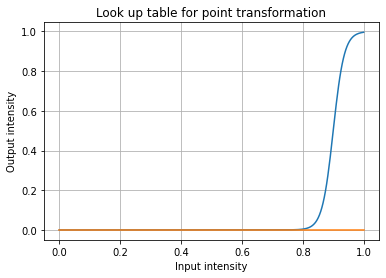

'\nk=0.085\ncent=255*0.5\nlut = 255/(1+np.exp(-k*(np.arange(256)-cent)))\nplt.plot(lut)\nplt.xlabel("Input intensity")\nplt.ylabel("Output intensity")\nplt.title("Look up table for point transformation")\nplt.grid()\nplt.show()\n'

In [16]:
cent=0.9
k=35

k= np.log(254)/cent if k<np.log(254)/cent  else k
k= np.log(254)/(1-cent) if k<np.log(254)/(1-cent) else k
print(k)
#k=5.413/cent

lut = 1/(1+np.exp(-k*(np.linspace(0,1,256)-cent)))
plt.plot(np.linspace(0,1,256), lut)
plt.plot([0,1],[0,0])
plt.xlabel("Input intensity")
plt.ylabel("Output intensity")
plt.title("Look up table for point transformation")
plt.grid()
plt.show()
'''
k=0.085
cent=255*0.5
lut = 255/(1+np.exp(-k*(np.arange(256)-cent)))
plt.plot(lut)
plt.xlabel("Input intensity")
plt.ylabel("Output intensity")
plt.title("Look up table for point transformation")
plt.grid()
plt.show()
'''

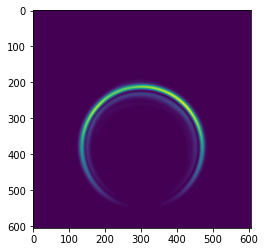

In [298]:
im = cv2.imread( "../EXPERIMENTAL/TEST_IMAGES/Reference__100.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(im)
plt.show()

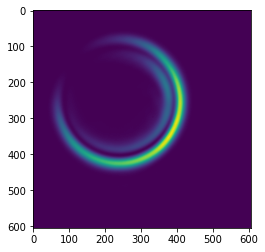

In [251]:
im = cv2.imread( "../EXPERIMENTAL/TEST_IMAGES/antes_de_la_estandar.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(im)
plt.show()

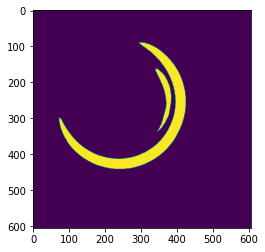

In [144]:
from skimage.filters import threshold_otsu
thresh = threshold_otsu(im)
binary = im > thresh

plt.imshow(binary)
plt.show()

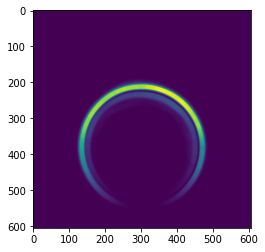

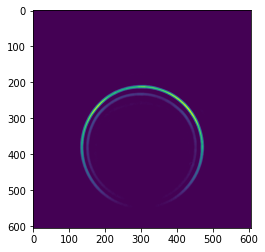

In [180]:
from skimage import color, morphology
footprint = morphology.disk(5)
res = morphology.white_tophat(im, footprint)
res2=im-res
plt.imshow(im-res)
plt.show()
plt.imshow(res)
plt.show()

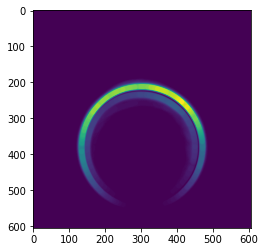

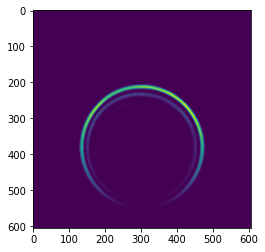

In [210]:
from skimage import color, morphology
footprint = morphology.disk(7)
res = morphology.white_tophat(im, footprint)
res2=im-res
plt.imshow(im-res)
plt.show()
plt.imshow(res)
plt.show()

In [239]:
np.repeat(footprint[np.newaxis, :,:], 5, axis=0).shape

(5, 15, 15)

In [221]:
ims = np.stack((im1, im2), 0)
footprint = morphology.disk(7)
foots = np.stack((footprint, footprint),0)
imso = morphology.opening(ims, foots)

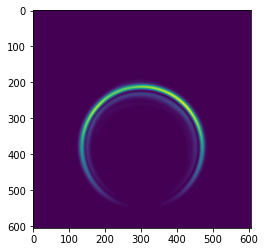

In [233]:
plt.imshow(ims[0])

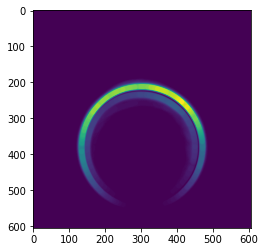

In [231]:
plt.imshow(imso[0])
plt.show()

In [235]:
np.array_equal(im2, imso[0])

True

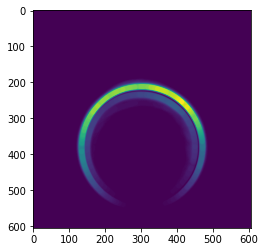

In [300]:
footprint = morphology.disk(7)

im2=morphology.opening(im, footprint)
plt.imshow(im2)
plt.show()

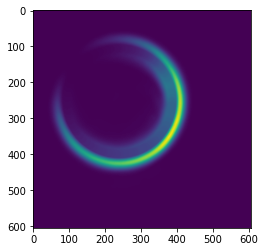

In [248]:
from skimage import color, morphology
footprint = morphology.disk(11)
res = morphology.black_tophat(im, footprint)
plt.imshow(im+res)
plt.show()

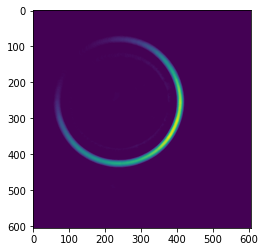

In [133]:
from skimage import color, morphology
footprint = morphology.disk(11)
res = morphology.black_tophat(im, footprint)
now=im+res
res2 = morphology.white_tophat(now, footprint)
plt.imshow(res2)
plt.show()

(605, 605) (605, 605)


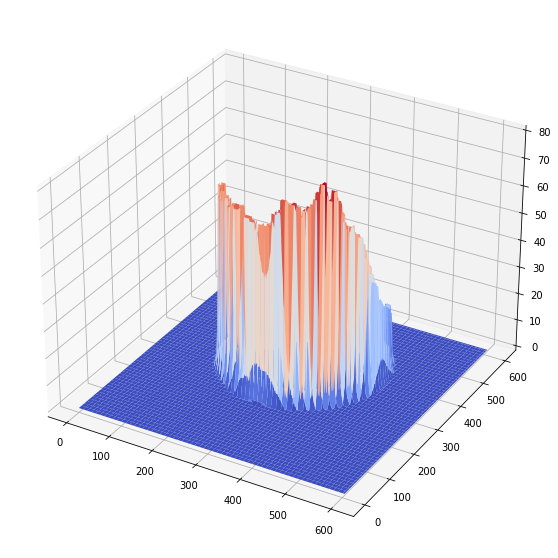

In [302]:
%matplotlib inline
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
every=1
X = np.linspace(0, im.shape[0], int(np.round(im.shape[0]/every)))
Y = np.linspace(0,im.shape[1],  int(np.round(im.shape[1]/every)))
X, Y = np.meshgrid(X, Y)
print(X.shape, im[::every, ::every].shape)
surf = ax.plot_surface(X, Y, im2[::every, ::every], cmap=cm.coolwarm,
                       linewidth=3, antialiased=True, rstride=10, cstride=10)
                       
plt.show()

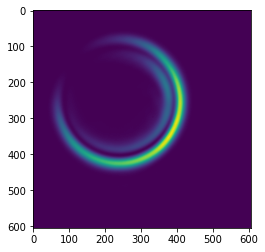

In [262]:
plt.imshow(ims[1])
plt.show()

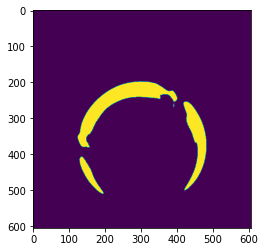

In [279]:
ths = threshold_local(ims, 31, offset=10)
b = ims[1]<ths[0]
plt.imshow(b)

In [283]:
local_threshold_binarization=lambda im: im < threshold_local(im, block_size=31, offset=10)

In [284]:
bins=1.0*np.array([ local_threshold_binarization(im) for im in ims])

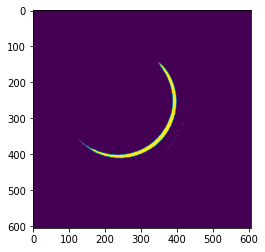

In [286]:
plt.imshow(bins[1])
plt.show()

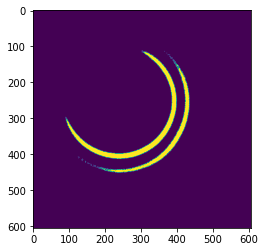

In [324]:
from skimage.filters import threshold_otsu, threshold_local, threshold_sauvola
block_size = 47
local_thresh = threshold_local(ims[1], block_size, offset=10)
#local_thresh = threshold_sauvola(im, block_size)
binary_local = ims[1] < local_thresh
plt.imshow(binary_local)
plt.show()

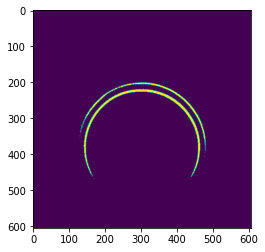

In [309]:
from skimage.filters import threshold_otsu, threshold_local, threshold_sauvola
block_size = 21
local_thresh = threshold_local(im, block_size, offset=10)
#local_thresh = threshold_sauvola(im, block_size)
binary_local = im < local_thresh
plt.imshow(binary_local)
plt.show()

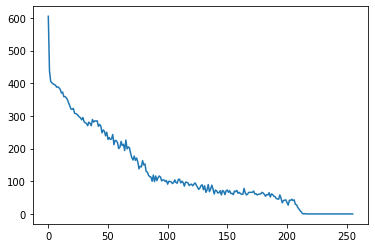

In [24]:
def hist(im):
    h = np.zeros(256)
    for i in im:
        h[i]+=1
    return h
plt.plot(hist(im))
plt.show()

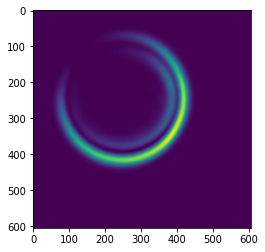

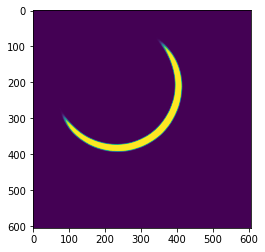

"\nout_im = sigmoid_lut_using_numpy_normalize_and_iX( torch.from_numpy(im).unsqueeze(0), in_are_dev=False, device=device, \n                                                  center=0.5, \n                       slope_squeezeness=k, max_val_lut_process=255, lut_process_dtype=torch.uint8,\n                       output_dtype=torch.float64, X=302 )\nplt.imshow(out_im[0].to('cpu').numpy())\nplt.show()\n"

In [73]:
im = cv2.imread( "../EXPERIMENTAL/TEST_IMAGES/con_los_dos.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(im)
plt.show()

def sigmoid_no_lut_normalize_and_iX( images, in_are_dev_float, device, center=0.7, 
                       slope_squeezeness=50, dtype=torch.float64, X=302 ):
    if not in_are_dev_float:
        images = images.type(dtype).to(device)    
    images = images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))   # normalize
    images = 1.0/(1+torch.exp(-slope_squeezeness*(images-center)))
    return compute_raws_to_centered_iXs_torch(images, X, device) # we need not noramlize them again if center if sigmoid chosen with sense
# Ojo! se usan los valores float del lut como valores de la imagen! (no los cuantizados!)


out_im = sigmoid_no_lut_normalize_and_iX(torch.from_numpy(im).unsqueeze(0), in_are_dev_float=False, 
                                         center = cent, device=device,
                                         slope_squeezeness=k)
plt.imshow(out_im[0].to('cpu').numpy())
plt.show()


'''
out_im = sigmoid_lut_using_numpy_normalize_and_iX( torch.from_numpy(im).unsqueeze(0), in_are_dev=False, device=device, 
                                                  center=0.5, 
                       slope_squeezeness=k, max_val_lut_process=255, lut_process_dtype=torch.uint8,
                       output_dtype=torch.float64, X=302 )
plt.imshow(out_im[0].to('cpu').numpy())
plt.show()
'''